In [1]:
from random import random

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
from functions import *
from CONSTANTS import *
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [2]:
class LLM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.1):
        super(LLM, self).__init__()

        # Store dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Attention tracking
        self.attention_scores_dict = {}
        self.last_attention_scores = []

        # Embedding layer maps input features to hidden dimension
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])

        # Layer normalization for stability
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(num_layers)
        ])

        # Self-attention mechanisms - now properly sized
        self.attention_weights = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])

        # Output layer
        self.output = nn.Linear(hidden_size, 1)

        # Activation
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He/Kaiming initialization for ReLU activations"""
        # Initialize embedding layer
        nn.init.kaiming_uniform_(self.embedding.weight, nonlinearity='relu')
        nn.init.zeros_(self.embedding.bias)
        
        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)
        
        # Initialize attention weights
        for attn in self.attention_weights:
            nn.init.kaiming_uniform_(attn.weight, nonlinearity='relu')
            nn.init.zeros_(attn.bias)
        
        # Initialize output layer 
        nn.init.kaiming_uniform_(self.output.weight, nonlinearity='relu')
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Reset attention dictionary at the start of each forward pass
        self.attention_scores_dict = {i: {} for i in range(batch_size)}
        self.last_attention_scores = []
        
        # Initial embedding
        x = self.embedding(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Process through hidden layers with attention
        for layer_idx, (layer, layer_norm, attention) in enumerate(zip(
            self.hidden_layers, self.layer_norms, self.attention_weights)):
            
            # Apply the hidden layer transformation first
            hidden = layer(x)
            
            # Calculate self-attention weights
            scores = attention(hidden)  # shape: [batch_size, hidden_size]
            scores = torch.softmax(scores, dim=1)  # shape: [batch_size, hidden_size]
            
            # Store attention scores for visualization/analysis
            self.last_attention_scores.append(scores)
            for i in range(batch_size):
                self.attention_scores_dict[i][f"layer_{layer_idx+1}"] = scores[i].detach()

            # Apply attention weights to the hidden state
            weighted_hidden = hidden * scores
            
            # Apply normalization, activation and dropout
            x = layer_norm(weighted_hidden)
            x = self.activation(x)
            x = self.dropout(x)

        # Final output
        output = self.output(x)

        return output

    def get_full_attention_dict(self, dataset_size):
        """Get a complete attention dictionary for all samples in dataset"""
        full_dict = {}
        for i in range(dataset_size):
            if i < len(self.attention_scores_dict):
                full_dict[i] = self.attention_scores_dict[i]
            else:
                # Fill missing entries with empty dictionaries
                full_dict[i] = {}
        return full_dict

    def reset_attention_tracking(self):
        """Reset attention tracking between runs"""
        self.attention_scores_dict = {}
        self.last_attention_scores = []

# Sample

input shape: torch.Size([10, 5])
target shape: torch.Size([10, 1])


Text(0, 0.5, 'MSE')

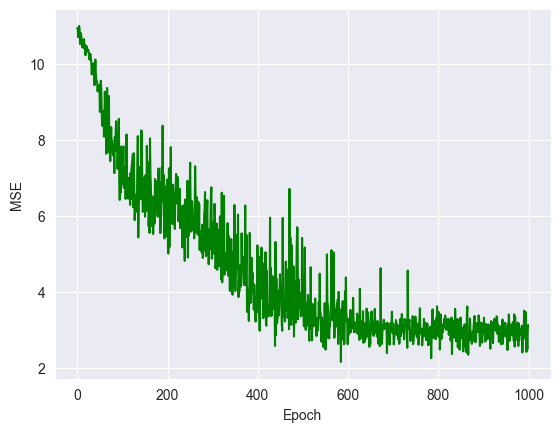

In [3]:
# Initialize the model
input_size = 5  # Number of previous numbers in the sequence
hidden_size = 128
num_layers = 2
model = LLM(input_size, hidden_size, num_layers)
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
data = [
    ([1, 2, 3, 4, 5], 6),
    ([2, 3, 4, 5, 6], 7),
    ([3, 4, 5, 6, 7], 8),
    ([4, 5, 6, 7, 8], 9),
    ([5, 6, 7, 8, 9], 10),
    ([6, 7, 8, 9, 10], 11),
    ([7, 8, 9, 10, 11], 12),
    ([8, 9, 10, 11, 12], 13),
    ([9, 10, 11, 12, 13], 14),
    ([10, 11, 12, 13, 14], 15)
]

# Convert data to tensors
inputs = torch.tensor([item[0] for item in data], dtype=torch.float32)
targets = torch.tensor([item[1] for item in data], dtype=torch.float32).unsqueeze(1)
print('input shape:', inputs.shape)
print('target shape:', targets.shape)

# Training loop
epochs = 1000
losses = []
for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets) ** 0.5

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e-2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

# Test the model
# test_data = range(11, 16, 1)
# test_input = torch.tensor([list(test_data)], dtype=torch.float32)
# predicted_output = model(test_input).item()
# print(f"Predicted next number: {predicted_output:.2f}")
pd.Series(losses).plot(color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [20]:
def average(attention_scores, index):
    tensor_list = list(attention_scores.get(index, {}).values())
    if tensor_list is None or tensor_list == []:
        return torch.tensor([])
    stacked = torch.stack(tensor_list)
    average = torch.mean(stacked, dim=0)
    return average

model.get_full_attention_dict(len(data)-10)

{0: {'layer_1': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'layer_2': tensor([0.0112, 0.0079, 0.0228, 0.0100, 0.0123, 0.0143, 0.0189, 0.0086, 0.0112,
          0.0115, 0.0196, 0.0143, 0.0149, 0.0156, 0.0125, 0.0114, 0.0156, 0.0218,
          0.0230, 0.0249, 0.0121, 0.0138, 0.0204, 0.0150, 0.0171, 0.0182, 0.0137,
          0.0119, 0.0234, 0.0110, 0.0205, 0.0137, 0.0117, 0.0093, 0.0144, 0.0217,
          0.0193, 0.0178, 0.0146, 0.0144, 0.0188, 0.0161, 0.0148, 0.0196, 0.0138,
          0.0137, 0.0113, 0.0127, 0.0185, 0.0224, 0.0155, 0.0197, 0.0174, 0.0180,
          0.0130, 0.0208, 0.0182, 0.0120, 0.0205, 0.0119, 0.0137, 0.0119, 0.0139,
          0.0156]),
  'layer_3': tensor([0.0239, 0.0168, 0.0085, 0.0099, 0.0062, 0.0040, 0.0174, 0.0041

# Try the NN for the full data

Preprocess bitcoin data

In [21]:
data = setup('BTC')[0]
data.set_index('time', inplace=True, drop=True)
data

low      high      open     close        volume   change  \
time                                                                        
2024-05-08  60851.04  63013.05  62315.75  61169.53   7486.425968 -1146.22   
2024-05-09  60601.60  63424.14  61169.53  63073.57   8360.055382  1904.04   
2024-05-10  60150.00  63470.00  63073.55  60787.47  11511.129910 -2286.08   
2024-05-11  60450.13  61482.00  60787.99  60814.63   2338.068108    26.64   
2024-05-12  60576.05  61843.45  60814.64  61453.02   2694.975779   638.38   
...              ...       ...       ...       ...           ...      ...   
2025-05-03  95765.13  96974.78  96929.81  95861.33   2077.556760 -1068.48   
2025-05-04  94151.67  96312.51  95865.47  94272.55   2834.396865 -1592.92   
2025-05-05  93500.01  95218.82  94272.54  94733.99   5180.158939   461.45   
2025-05-06  93363.28  96916.25  94733.99  96839.17   6163.867558  2105.18   
2025-05-07  96207.28  97738.05  96843.84  97061.99   4431.918646   218.15   

            pct_change      SMA_20      SMA_50        EMA_20  ...  \
time                                                          ...   
2024-05-08   -1.839374  65890.2210  66417.9682  64677.302333  ...   
2024-05-09    3.112726  66247.8435  66426.8854  65046.541526  ...   
2024-05-10   -3.624467  66472.6375  66371.6810  65254.222740  ...   
2024-05-11    0.043824  66850.1930  66373.6450  65724.407239  ...   
2024-05-12    1.049714  67183.0820  66410.7176  66241.225895  ...   
...                ...         ...         ...           ...  ...   
2025-05-03   -1.102323  72647.6545  69787.8322  76875.959487  ...   
2025-05-04   -1.661620  71251.6105  69155.3058  74877.499433  ...   
2025-05-05    0.489485  69965.3730  68533.2834  72835.915163  ...   
2025-05-06    2.222201  68693.1570  67843.8636  70530.854654  ...   
2025-05-07    0.225260  67274.8845  67142.8744  67761.558302  ...   

            Unnamed: 0.1  Unnamed: 0  title  date  link  text  sentiment  \
time                                                                       
2024-05-08           0.0         0.0      -   NaN     -     -          -   
2024-05-09           0.0         0.0      -   NaN     -     -          -   
2024-05-10           0.0         0.0      -   NaN     -     -          -   
2024-05-11           0.0         0.0      -   NaN     -     -          -   
2024-05-12           0.0         0.0      -   NaN     -     -          -   
...                  ...         ...    ...   ...   ...   ...        ...   
2025-05-03           0.0         0.0      -   NaN     -     -          -   
2025-05-04           0.0         0.0      -   NaN     -     -          -   
2025-05-05           0.0         0.0      -   NaN     -     -          -   
2025-05-06           0.0         0.0      -   NaN     -     -          -   
2025-05-07           0.0         0.0      -   NaN     -     -          -   

            score  gradient  TextType  
time                                   
2024-05-08    0.0      0.00     tweet  
2024-05-09    0.0   1904.04     tweet  
2024-05-10    0.0  -2286.10     tweet  
2024-05-11    0.0     27.16     tweet  
2024-05-12    0.0    638.39     tweet  
...           ...       ...       ...  
2025-05-03    0.0  -1068.48     tweet  
2025-05-04    0.0  -1588.78     tweet  
2025-05-05    0.0    461.44     tweet  
2025-05-06    0.0   2105.18     tweet  
2025-05-07    0.0    222.82     tweet  

[437 rows x 37 columns]

In [22]:
sequences = []
for i in range(len(data)-1):
    # create a sequence of all the previous values followed by the next one
    # to be separated into different columns at the bottom
    sequences.append(sequence(data['gradient'], i))

last = data['gradient'].values.tolist() # address the last value
item = (last, 0)
sequences.append(item)

# add it to the data and separate
# padding required to make it go through
data['list'] = [i[0] for i in sequences]
data['list'] = data['list'].apply(lambda a: padding(a, len(data)))
data['next'] = [i[1] for i in sequences]
data[['gradient', 'list', 'next']]

gradient                                               list  \
time                                                                      
2024-05-08      0.00  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-09   1904.04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-10  -2286.10  [0.0, 1904.0400000000009, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-11     27.16  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-12    638.39  [0.0, 1904.0400000000009, -2286.0999999999985,...   
...              ...                                                ...   
2025-05-03  -1068.48  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-04  -1588.78  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-05    461.44  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-06   2105.18  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-05-07    222.82  [0.0, 1904.0400000000009, -2286.0999999999985,...   

               next  
time                 
2024-05-08  1904.04  
2024-05-09 -2286.10  
2024-05-10    27.16  
2024-05-11   638.39  
2024-05-12  1479.35  
...             ...  
2025-05-03 -1588.78  
2025-05-04   461.44  
2025-05-05  2105.18  
2025-05-06   222.82  
2025-05-07     0.00  

[437 rows x 3 columns]

### Fit the model on the list and next

Preprocessing & Train Test Split

In [23]:
TRAIN_PCT = 0.8
train = data[:int(len(data) * TRAIN_PCT)]
test = data[int(len(data) * TRAIN_PCT):]
X = train[['list']]
y = train['next']

X_train_full = X.copy()
y_train_full = y.copy()
X_test_full = test[['list']]
y_test_full = test['next']

tscv = TimeSeriesSplit(n_splits=5)
splits = tscv.split(X)
X_trains = []
y_trains = []
X_tests = []
y_tests = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

Fit the model

In [24]:
import copy
from tqdm import tqdm

def fit_llm(X_train, y_train, X_test, y_test, hidden_size=64, num_layers=2, 
           epochs=100, lr=1e-2, early_stopping_patience=15, dropout_rate=0.1):
    # Get actual input size from your data
    input_size = len(X_train['list'].iloc[0])
    print(f"Input size: {input_size}")

    # Initialize model with correct input size and dropout
    model = LLM(input_size, hidden_size, num_layers, dropout_rate)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Added weight decay
    
    # Learning rate scheduler with reduced patience for faster adaptation
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    # Convert to tensors
    inputs = torch.tensor(X_train['list'].tolist(), dtype=torch.float32)
    targets = torch.tensor(y_train.tolist(), dtype=torch.float32).unsqueeze(1)
    
    # Prepare validation data
    val_inputs = torch.tensor(X_test['list'].tolist(), dtype=torch.float32)
    val_targets = torch.tensor(y_test.tolist(), dtype=torch.float32).unsqueeze(1)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    for i in tqdm(range(epochs)):
        # Training step
        model.train()
        optimizer.zero_grad()
        
        predictions = model(inputs)
        train_loss = torch.sqrt(loss_function(predictions, targets))  # RMSE

        # Backward pass and optimization
        train_loss.backward()
        
        # Gradient clipping with higher threshold
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_inputs)
            val_loss = torch.sqrt(loss_function(val_predictions, val_targets))
            val_losses.append(val_loss.item())
            
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model = copy.deepcopy(model)
        else:
            patience_counter += 1
            
        
    
    # Use the best model for final evaluation
    if best_model is not None:
        model = best_model
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_predictions = model(val_inputs)
        test_loss = torch.sqrt(loss_function(test_predictions, val_targets))
    
    print(f"Final validation RMSE: {test_loss.item():.4f}")

    return model, train_losses, val_losses, test_loss.item(), test_predictions.detach().numpy()

Input size: 437


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 1000/1000 [00:02<00:00, 478.95it/s]


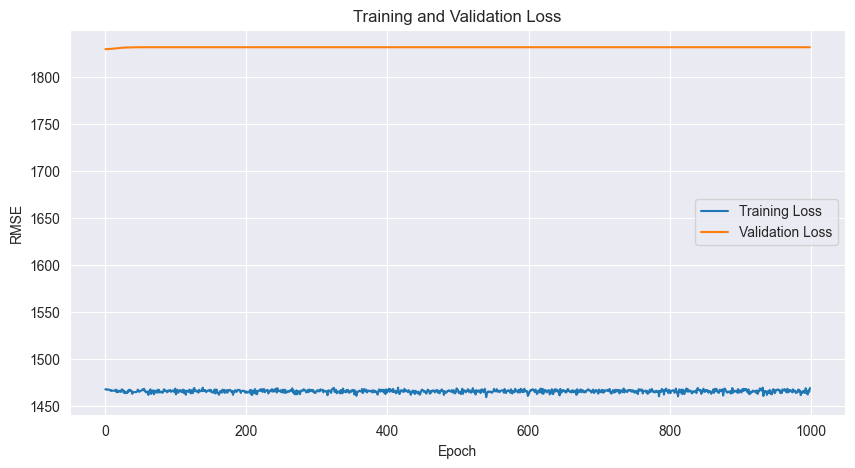

Final validation RMSE: 1828.9777


In [9]:
idx = 0
theModel, train_losses, val_losses, test_loss, test_predictions = fit_llm(X_trains[idx], y_trains[idx], X_tests[idx], y_tests[idx], hidden_size=64, num_layers=2, epochs=1000, lr=1e-1)

In [25]:
train_losses

[1867.724365234375,
 1867.794921875,
 1867.72119140625,
 1867.709716796875,
 1867.673828125,
 1867.691162109375,
 1867.7412109375,
 1867.6650390625,
 1867.66015625,
 1867.68408203125,
 1867.6326904296875,
 1867.6839599609375,
 1867.572265625,
 1867.6654052734375,
 1867.6112060546875,
 1867.647705078125,
 1867.6785888671875,
 1867.626708984375,
 1867.6181640625,
 1867.6270751953125,
 1867.6719970703125,
 1867.6513671875,
 1867.62646484375,
 1867.523193359375,
 1867.553955078125,
 1867.642578125,
 1867.498046875,
 1867.5589599609375,
 1867.59130859375,
 1867.57568359375,
 1867.5333251953125,
 1867.5826416015625,
 1867.58984375,
 1867.6177978515625,
 1867.639404296875,
 1867.549072265625,
 1867.683349609375,
 1867.64013671875,
 1867.54248046875,
 1867.5721435546875,
 1867.5928955078125,
 1867.461181640625,
 1867.6158447265625,
 1867.63818359375,
 1867.5458984375,
 1867.547607421875,
 1867.570556640625,
 1867.517822265625,
 1867.596923828125,
 1867.5230712890625,
 1867.6002197265625,
 1867

In [26]:
averages = []
theData = X_trains[idx]
for i in range(len(theData)):
    avg = average(theModel.attention_scores_dict, i)
    averages.append(avg)
theData['attentions'] = averages

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_27963/3970097156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theData['attentions'] = averages


In [27]:
theData[['list', 'attentions']]

list  \
time                                                            
2024-05-08  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-09  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-10  [0.0, 1904.0400000000009, 0.0, 0.0, 0.0, 0.0, ...   
2024-05-11  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2024-05-12  [0.0, 1904.0400000000009, -2286.0999999999985,...   
...                                                       ...   
2025-02-01  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-02-02  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-02-03  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-02-04  [0.0, 1904.0400000000009, -2286.0999999999985,...   
2025-02-05  [0.0, 1904.0400000000009, -2286.0999999999985,...   

                                                   attentions  
time                                                           
2024-05-08  [tensor(0.0162), tensor(0.0011), tensor(0.0010...  
2024-05-09  [tensor(0.0162), tensor(0.0011), tensor(0.0010...  
2024-05-10  [tensor(0.0162), tensor(0.0011), tensor(0.0010...  
2024-05-11  [tensor(0.0162), tensor(0.0011), tensor(0.0010...  
2024-05-12  [tensor(0.0162), tensor(0.0011), tensor(0.0010...  
...                                                       ...  
2025-02-01                                                 []  
2025-02-02                                                 []  
2025-02-03                                                 []  
2025-02-04                                                 []  
2025-02-05                                                 []  

[291 rows x 2 columns]

## Cross Validation for My LLM

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 1 - Train size: 59, Test size: 58
Input size: 437


100%|██████████| 1000/1000 [00:07<00:00, 130.02it/s]


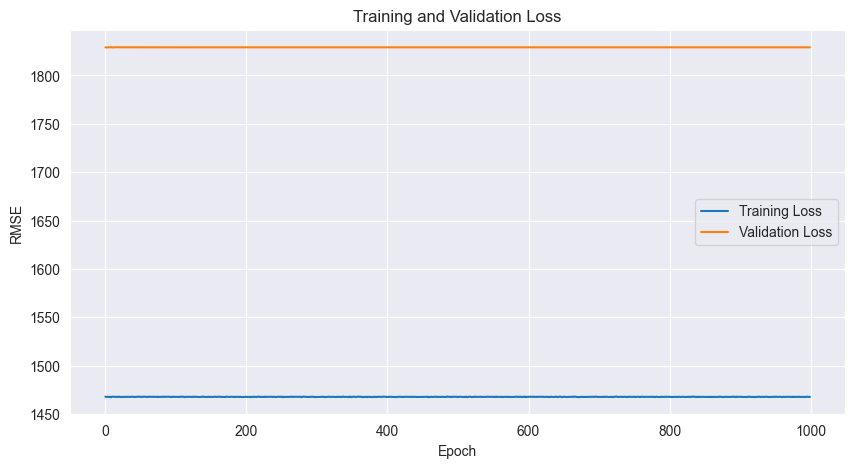

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_27963/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 1828.9023
Fold 2 - Train size: 117, Test size: 58
Input size: 437


100%|██████████| 1000/1000 [00:09<00:00, 102.33it/s]


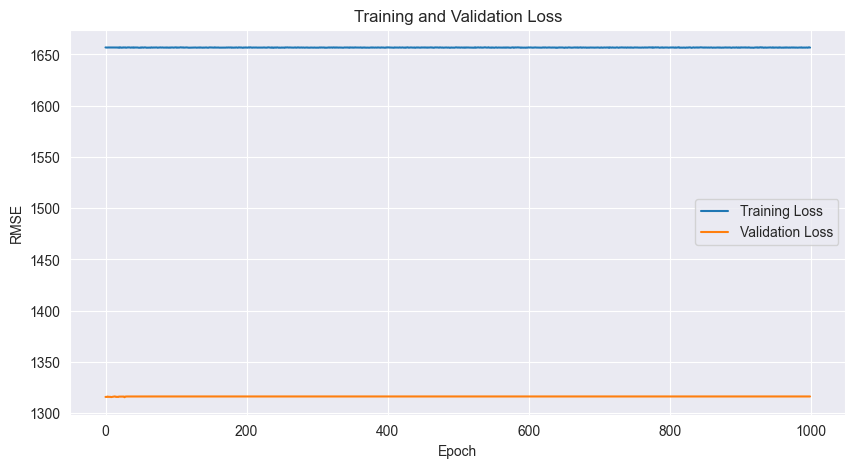

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_27963/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 1315.4935
Fold 3 - Train size: 175, Test size: 58
Input size: 437


100%|██████████| 1000/1000 [00:11<00:00, 87.38it/s]


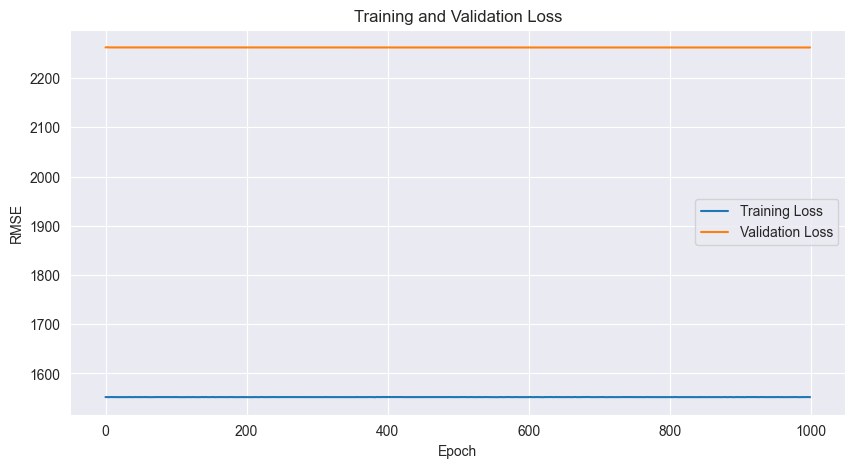

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_27963/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 2262.0420
Fold 4 - Train size: 233, Test size: 58
Input size: 437


100%|██████████| 1000/1000 [00:12<00:00, 80.75it/s]


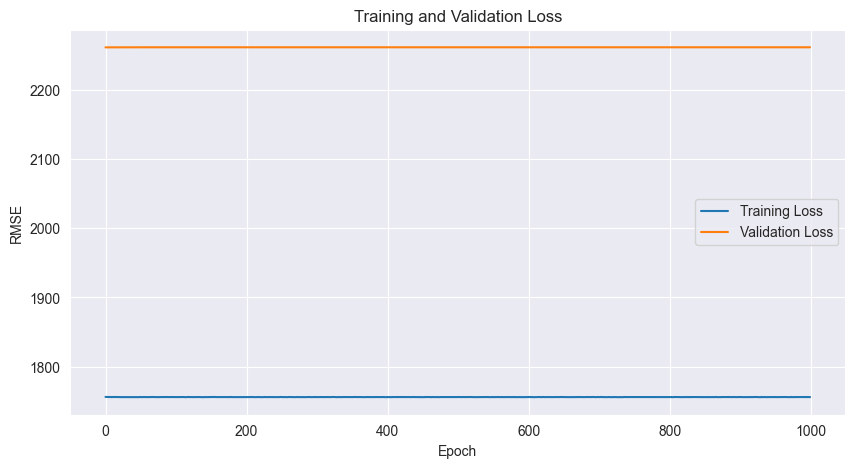

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_27963/690836615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['attentions'] = averages
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final validation RMSE: 2261.7207
Fold 5 - Train size: 291, Test size: 58
Input size: 437


100%|██████████| 1000/1000 [00:13<00:00, 72.84it/s]


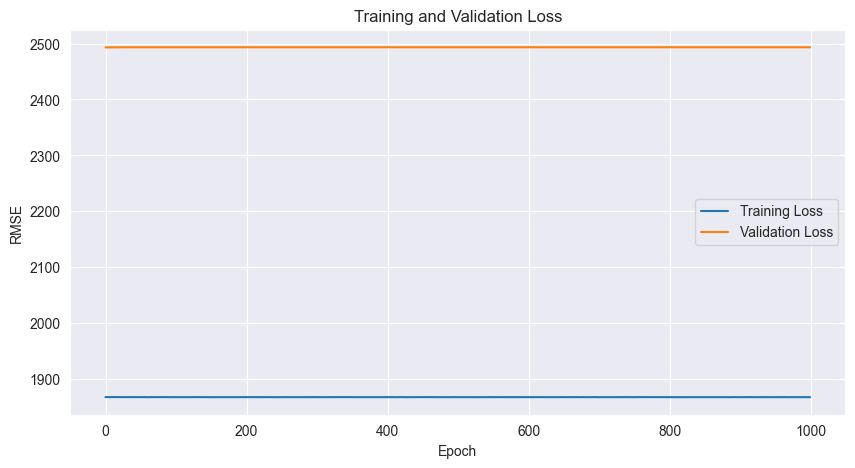

Final validation RMSE: 2493.1011


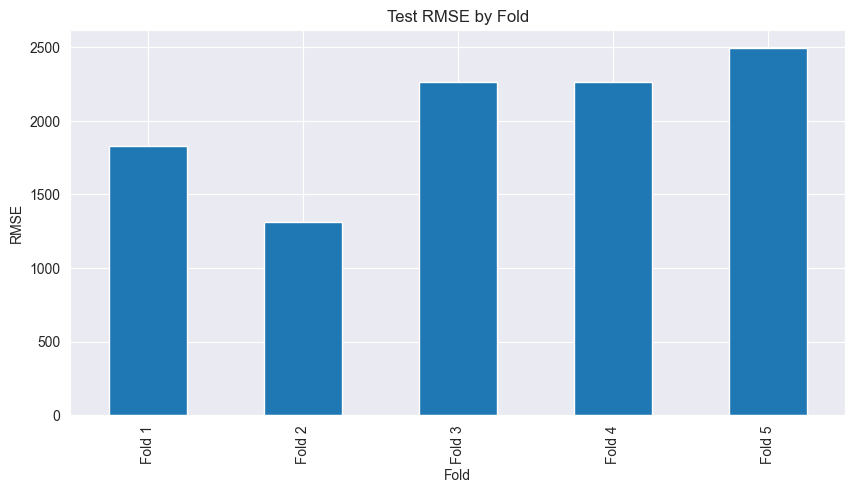

In [28]:
testLosses = []
for idx, (X_train, X_test, y_train, y_test) in enumerate(zip(X_trains, X_tests, y_trains, y_tests)):
    print(f"Fold {idx+1} - Train size: {len(X_train)}, Test size: {len(X_test)}")
    model, train_losses, val_losses, test_loss, test_predictions = fit_llm(X_train, y_train, X_test, y_test, hidden_size=64, num_layers=10, epochs=1000, lr=1e-3)
    
    # After training, process attention scores for this fold
    averages = []
    for i in range(len(X_train)):
        if i < len(model.attention_scores_dict):
            avg = average(model.attention_scores_dict, i)
        else:
            # Create placeholder tensor for missing entries
            avg = torch.zeros(len(X_train['list'].iloc[0]))
        averages.append(avg)
    
    # Store attention values and results
    X_train['attentions'] = averages
    testLosses.append(test_loss)

# Plot results
pd.Series(testLosses).plot.bar(figsize=(10, 5))
plt.title('Test RMSE by Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(range(len(testLosses)), [f'Fold {i+1}' for i in range(len(testLosses))])
plt.grid(True, axis='y')

In [29]:
np.array(testLosses).mean()

2032.2519287109376

The model does the best on Fold 2.

## Hyperparameter Tuning

In [30]:
def tune_hyperparameters(X_trains, y_trains, X_tests, y_tests, 
                        hidden_sizes=[32, 64, 128], 
                        layers_options=[2, 5, 10], 
                        learning_rates=[1e-4, 1e-3, 1e-2],
                        epochs=500, 
                        verbose=True):
    """
    Tune hyperparameters for LLM model using grid search
    
    Parameters:
    -----------
    X_trains, y_trains, X_tests, y_tests: Lists of train/test data from cross-validation
    hidden_sizes: List of hidden size options to try
    layers_options: List of layer count options to try
    learning_rates: List of learning rate options to try
    epochs: Number of epochs for each model training
    verbose: Whether to print progress details
    
    Returns:
    --------
    best_params: Dictionary of best parameters
    results_df: DataFrame with all results
    """
    import itertools
    from tqdm.notebook import tqdm
    
    # Create all combinations of hyperparameters
    param_grid = list(itertools.product(hidden_sizes, layers_options, learning_rates))
    
    # Store results
    results = []
    best_rmse = float('inf')
    best_params = {}
    
    # Progress bar for all combinations
    total_combinations = len(param_grid)
    if verbose:
        print(f"Tuning {total_combinations} hyperparameter combinations...")
    
    # Loop through all combinations
    for hidden_size, num_layers, lr in tqdm(param_grid):
        if verbose:
            print(f"\nTesting: hidden_size={hidden_size}, layers={num_layers}, lr={lr}")
        
        # Run cross-validation
        fold_losses = []
        fold_train_losses = []
        fold_val_losses = []
        
        for fold, (X_train, y_train, X_test, y_test) in enumerate(zip(X_trains, y_trains, X_tests, y_tests)):
            if verbose:
                print(f"  Fold {fold+1}/{len(X_trains)}")
            
            # Train model with current hyperparameters
            model, train_losses, val_losses, test_loss, _ = fit_llm(
                X_train, y_train, X_test, y_test,
                hidden_size=hidden_size,
                num_layers=num_layers,
                epochs=epochs,
                lr=lr
            )
            
            fold_losses.append(test_loss)
            fold_train_losses.append(train_losses[-1])  # Final training loss
            fold_val_losses.append(val_losses[-1])      # Final validation loss
        
        # Calculate average metrics across folds
        avg_rmse = np.mean(fold_losses)
        avg_train_loss = np.mean(fold_train_losses)
        avg_val_loss = np.mean(fold_val_losses)
        std_rmse = np.std(fold_losses)
        
        # Store results
        results.append({
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': lr,
            'avg_rmse': avg_rmse,
            'std_rmse': std_rmse,
            'avg_train_loss': avg_train_loss,
            'avg_val_loss': avg_val_loss,
            'fold_losses': fold_losses
        })
        
        if verbose:
            print(f"  Avg RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")
        
        # Update best parameters if we found a better model
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'learning_rate': lr
            }
            if verbose:
                print(f"  New best model found!")
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Sort by average RMSE
    results_df = results_df.sort_values('avg_rmse')
    
    # Print best parameters
    if verbose:
        print("\n" + "="*50)
        print(f"Best parameters: hidden_size={best_params['hidden_size']}, "
              f"num_layers={best_params['num_layers']}, "
              f"learning_rate={best_params['learning_rate']}")
        print(f"Best average RMSE: {best_rmse:.4f}")
        print("="*50)
    
    return best_params, results_df

Tuning 27 hyperparameter combinations...


  0%|          | 0/27 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Testing: hidden_size=32, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:00<00:00, 575.78it/s]


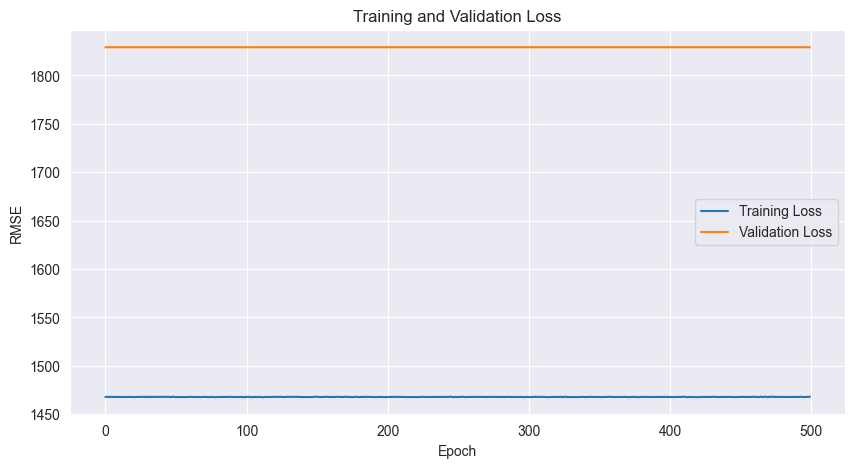

Final validation RMSE: 1829.1504
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 491.10it/s]


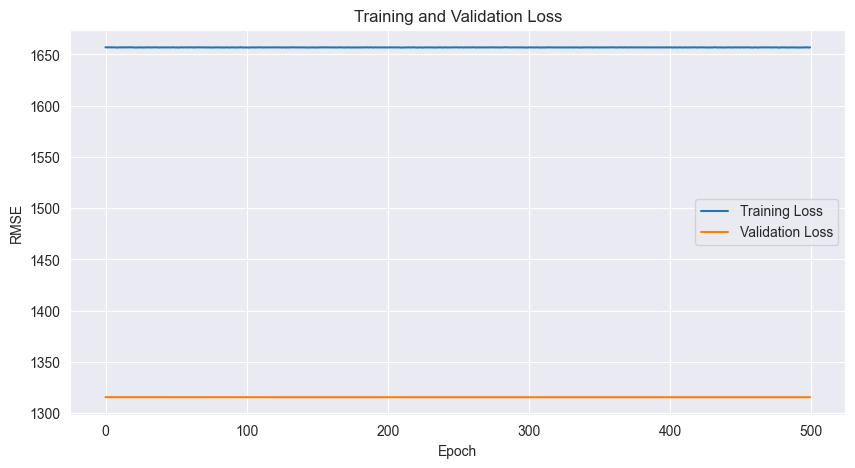

Final validation RMSE: 1315.6447
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 458.99it/s]


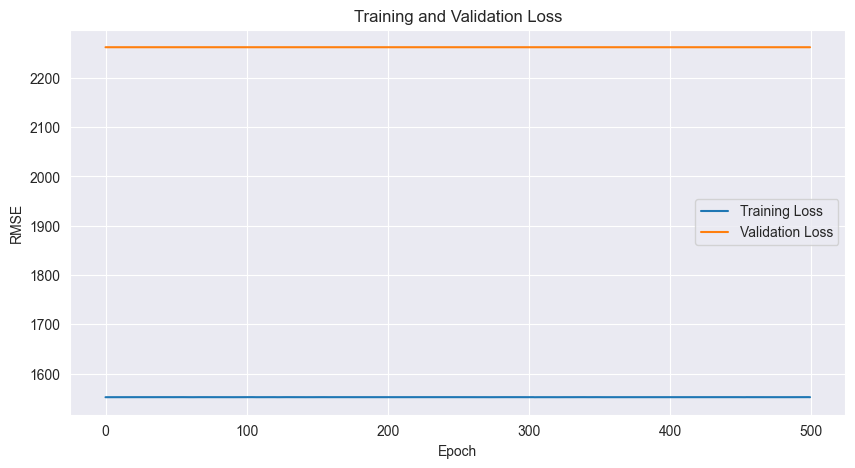

Final validation RMSE: 2262.3669
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 421.34it/s]


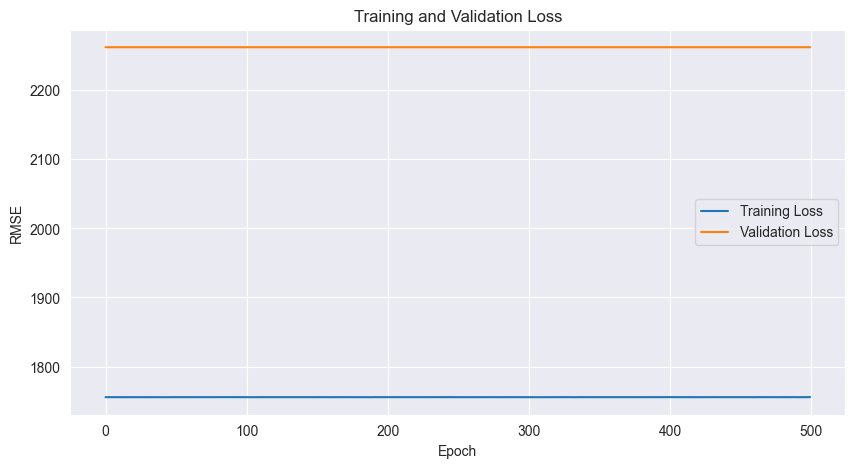

Final validation RMSE: 2261.7815
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 356.63it/s]


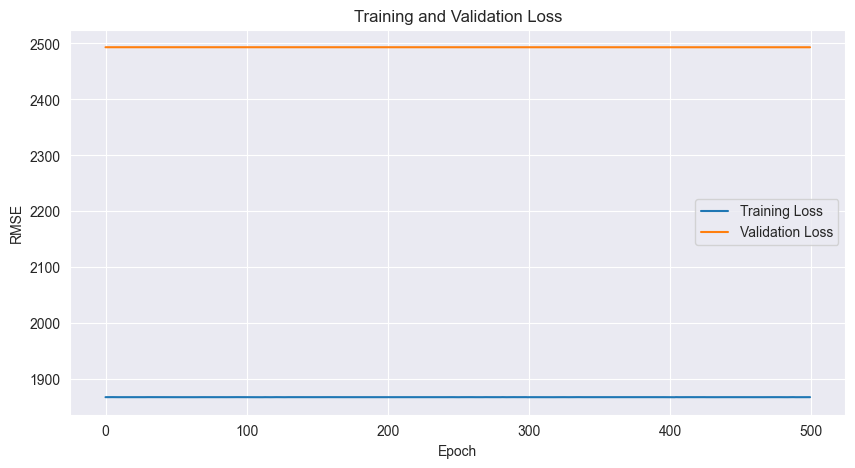

Final validation RMSE: 2493.2336
  Avg RMSE: 2032.4354 ± 417.8318
  New best model found!

Testing: hidden_size=32, layers=2, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:00<00:00, 600.01it/s]


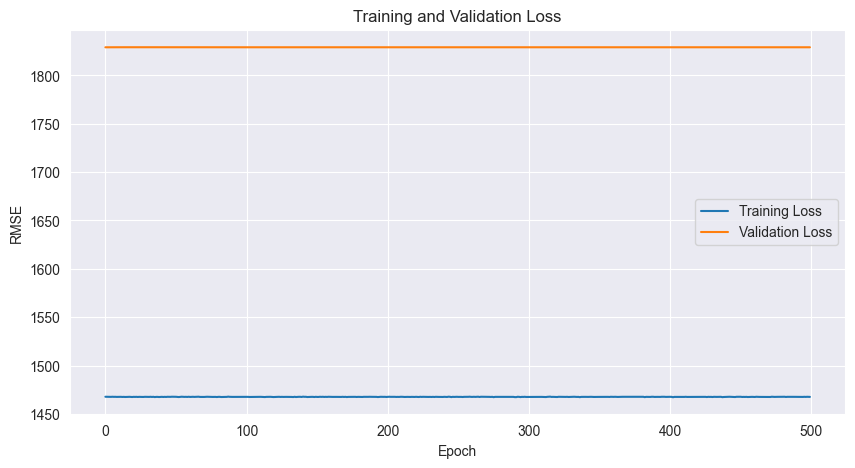

Final validation RMSE: 1828.9896
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 496.68it/s]


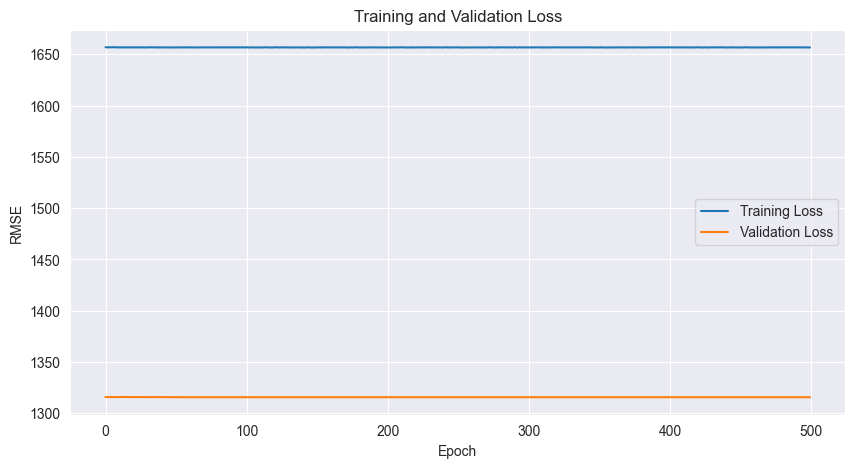

Final validation RMSE: 1315.5496
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 382.13it/s]


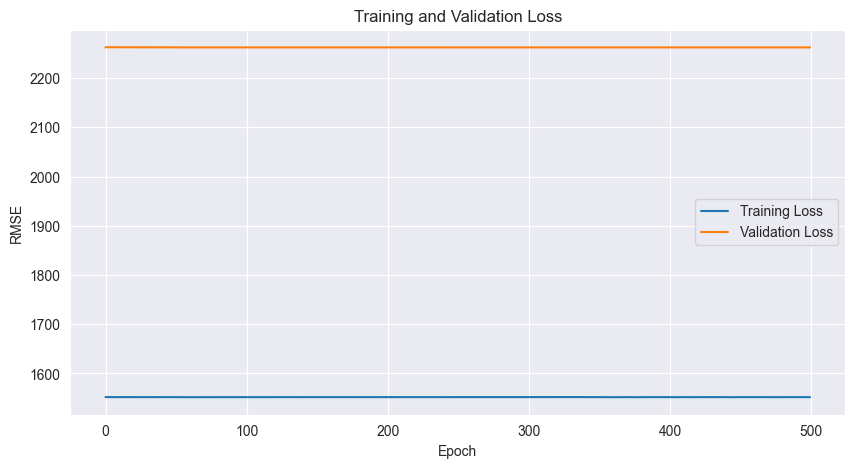

Final validation RMSE: 2262.1855
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 391.22it/s]


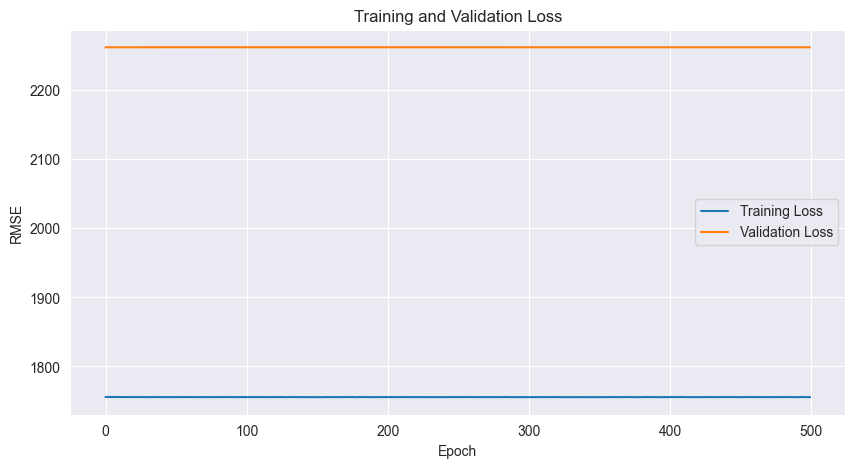

Final validation RMSE: 2261.7070
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 369.73it/s]


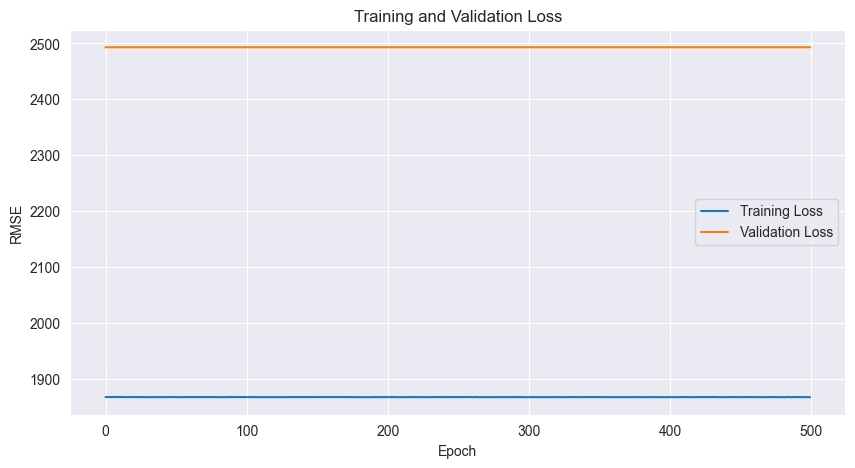

Final validation RMSE: 2493.0068
  Avg RMSE: 2032.2877 ± 417.8019
  New best model found!

Testing: hidden_size=32, layers=2, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:00<00:00, 597.65it/s]


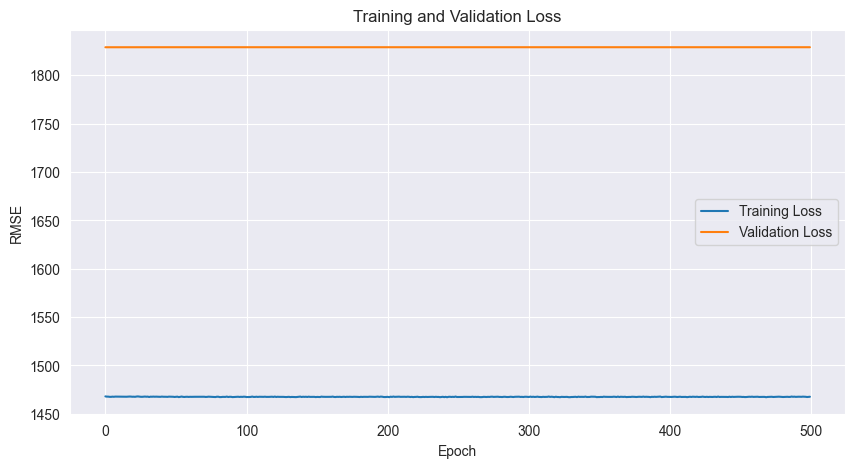

Final validation RMSE: 1829.0063
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:00<00:00, 512.59it/s]


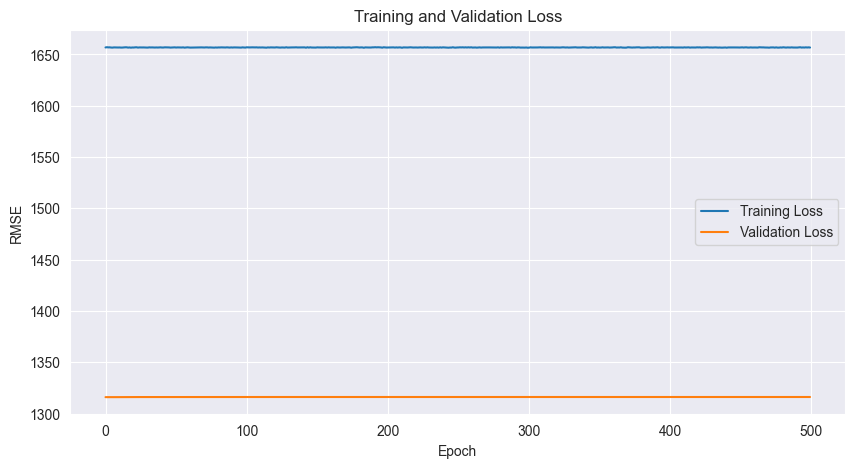

Final validation RMSE: 1315.9261
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 339.22it/s]


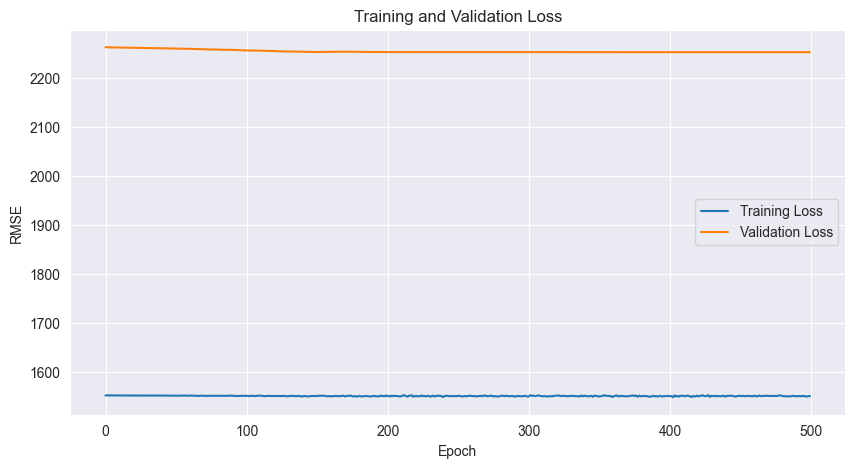

Final validation RMSE: 2251.9941
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 412.81it/s]


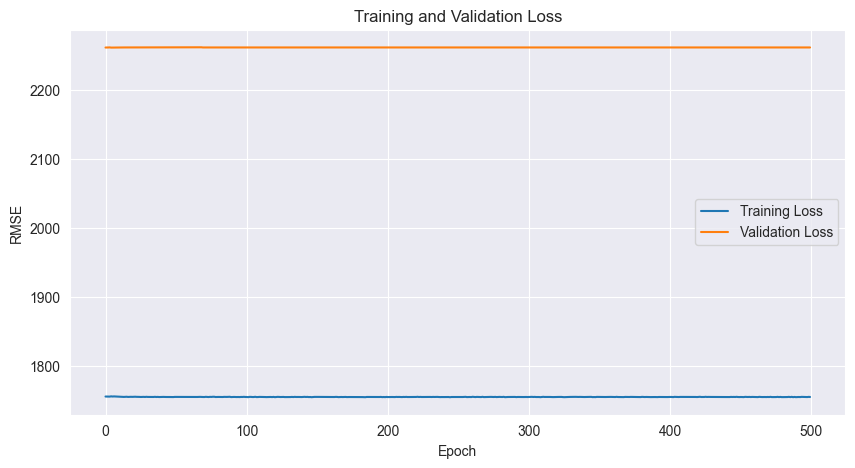

Final validation RMSE: 2261.7083
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 365.55it/s]


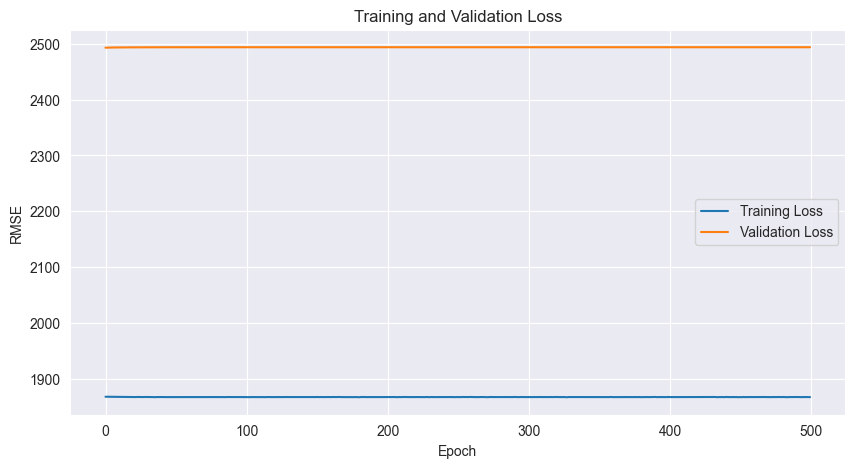

Final validation RMSE: 2493.1736
  Avg RMSE: 2030.3617 ± 416.6051
  New best model found!

Testing: hidden_size=32, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 277.83it/s]


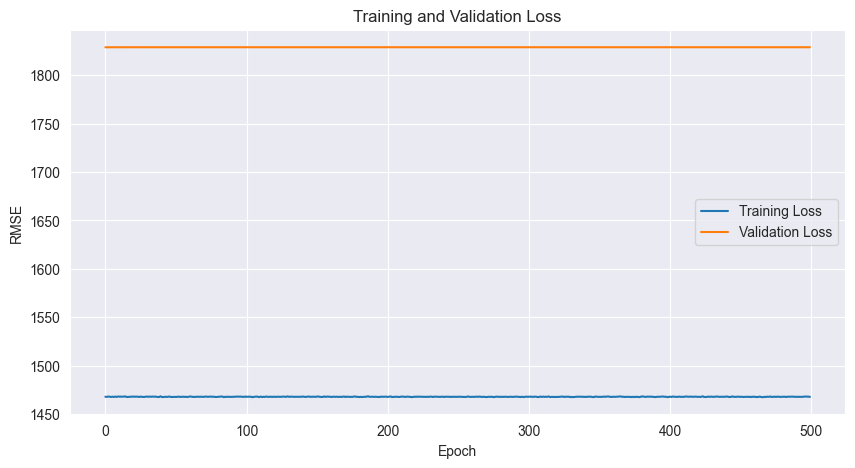

Final validation RMSE: 1828.7661
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 251.49it/s]


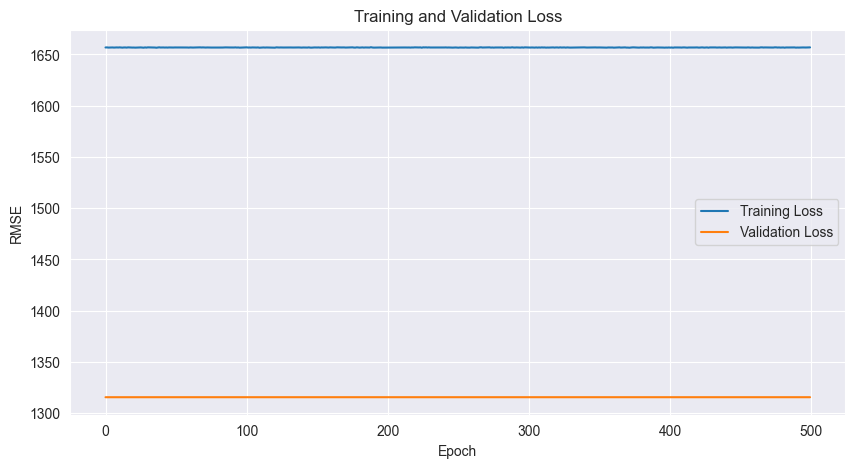

Final validation RMSE: 1315.6154
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 199.01it/s]


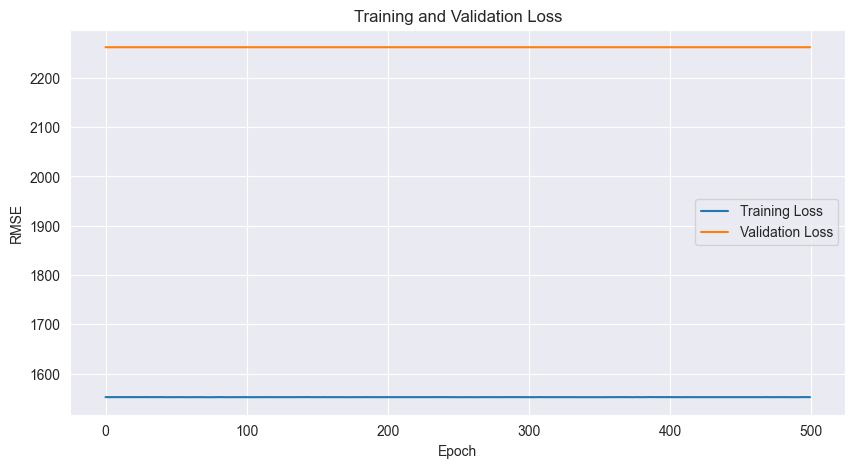

Final validation RMSE: 2262.3513
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 186.11it/s]


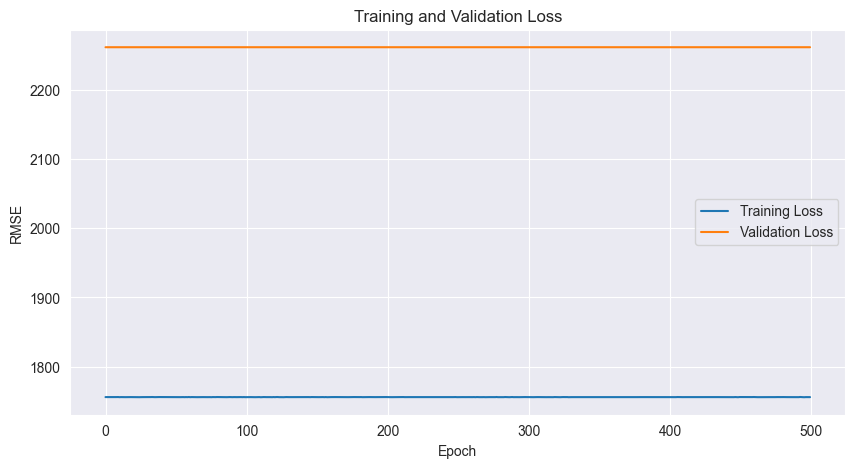

Final validation RMSE: 2261.7744
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 155.06it/s]


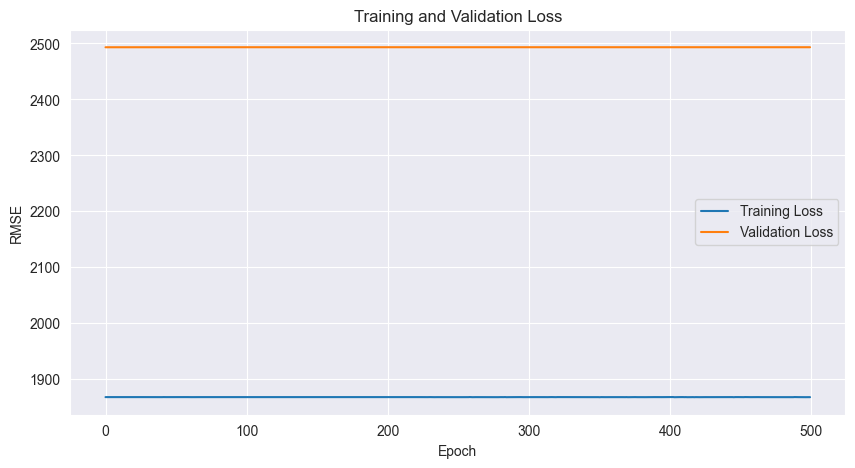

Final validation RMSE: 2493.1248
  Avg RMSE: 2032.3264 ± 417.8527

Testing: hidden_size=32, layers=5, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 267.89it/s]


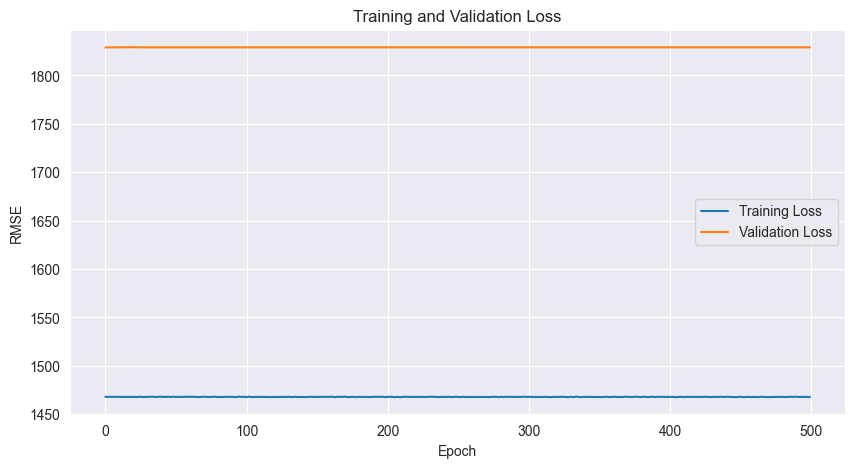

Final validation RMSE: 1828.8448
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 251.07it/s]


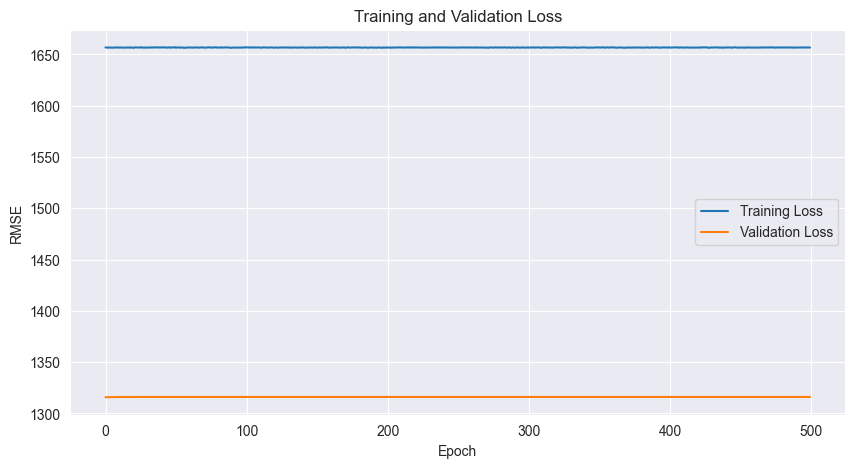

Final validation RMSE: 1315.7247
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 203.33it/s]


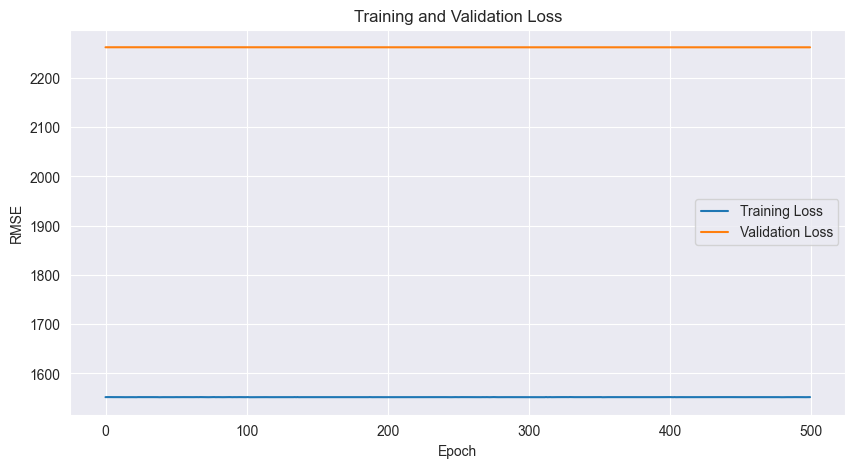

Final validation RMSE: 2262.1804
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 182.60it/s]


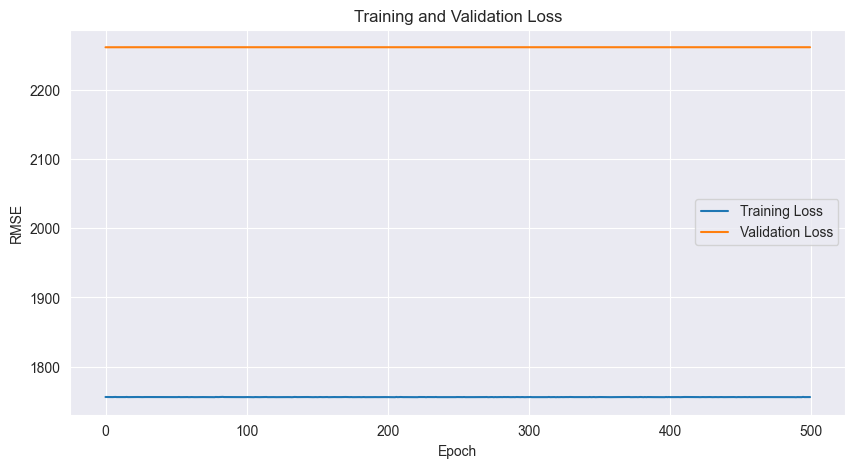

Final validation RMSE: 2261.7834
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 162.74it/s]


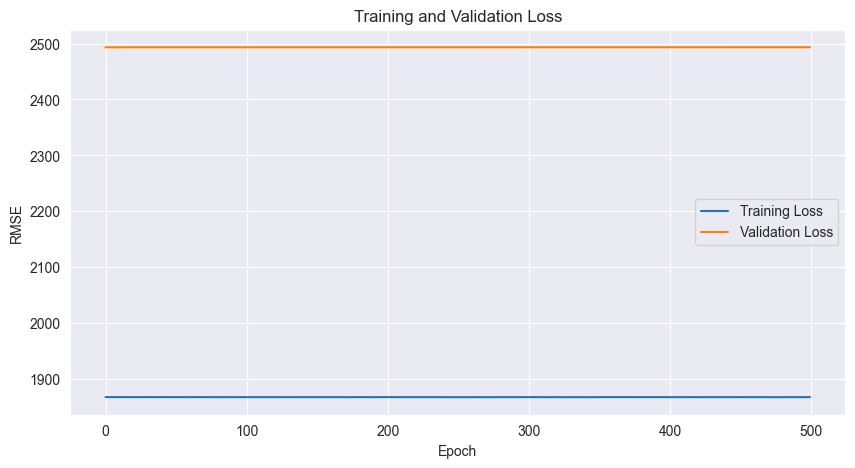

Final validation RMSE: 2493.2603
  Avg RMSE: 2032.3587 ± 417.8196

Testing: hidden_size=32, layers=5, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 290.43it/s]


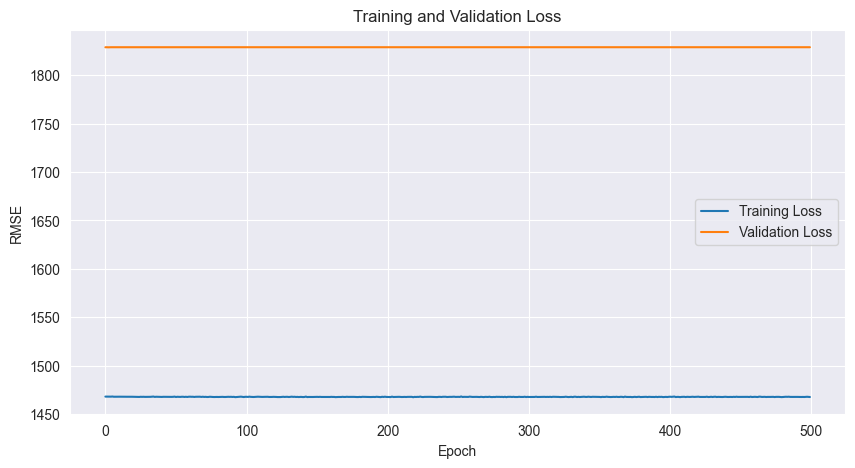

Final validation RMSE: 1828.9130
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 252.77it/s]


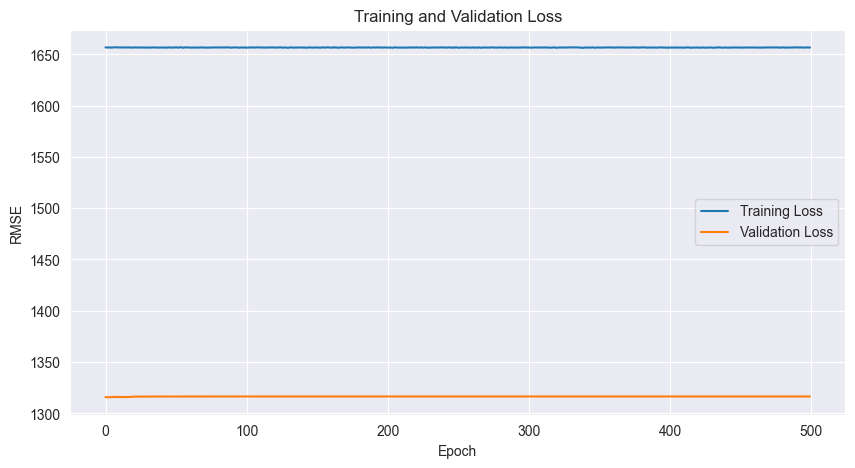

Final validation RMSE: 1315.7123
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 174.55it/s]


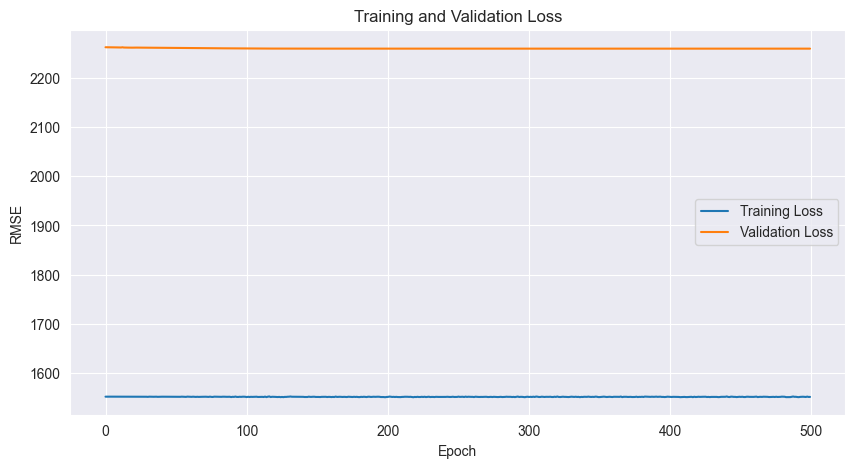

Final validation RMSE: 2259.4871
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 196.54it/s]


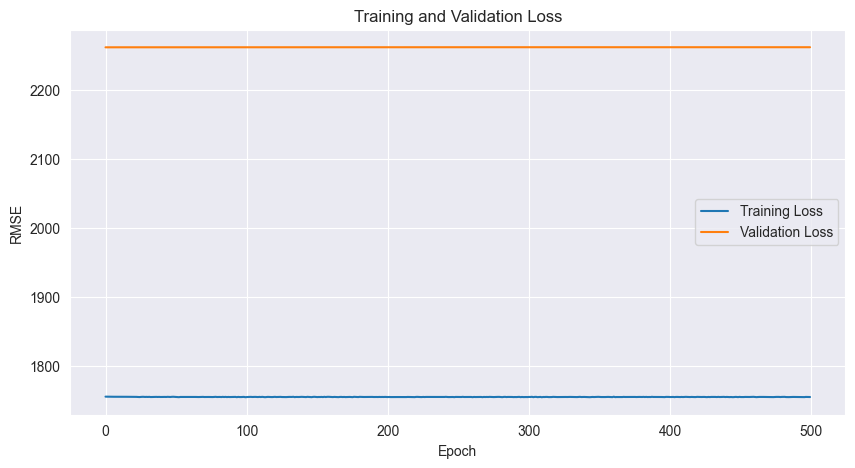

Final validation RMSE: 2261.8174
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 161.82it/s]


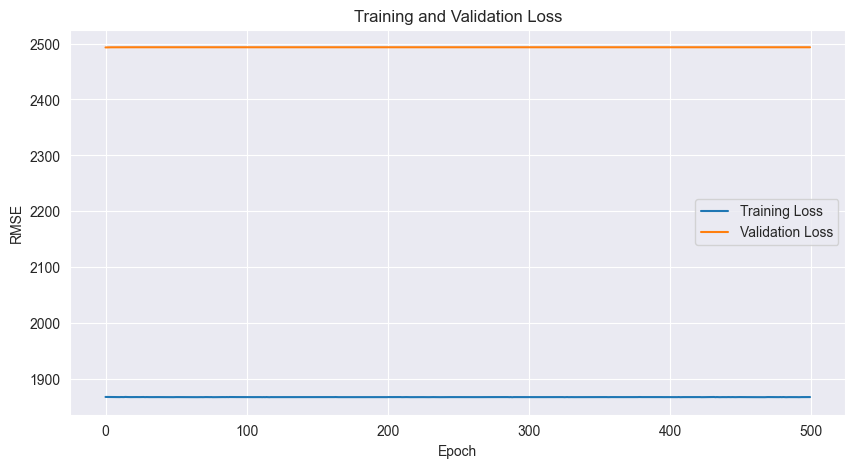

Final validation RMSE: 2493.1562
  Avg RMSE: 2031.8172 ± 417.5030

Testing: hidden_size=32, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 145.36it/s]


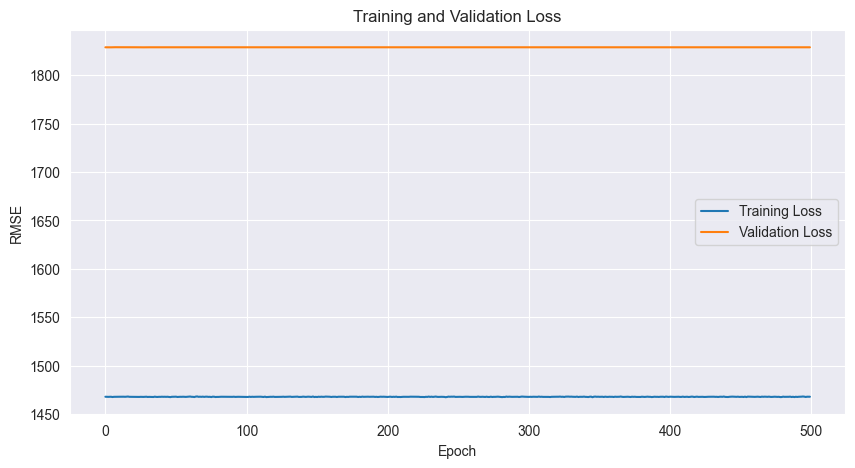

Final validation RMSE: 1828.8345
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 116.77it/s]


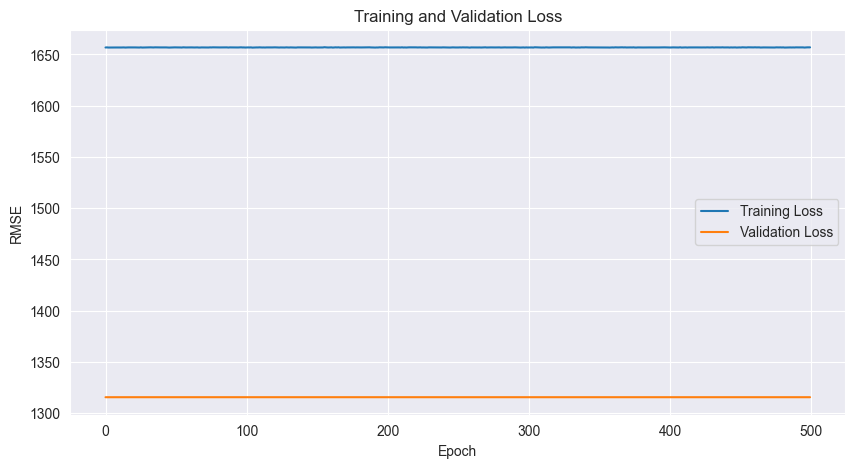

Final validation RMSE: 1315.5635
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 110.74it/s]


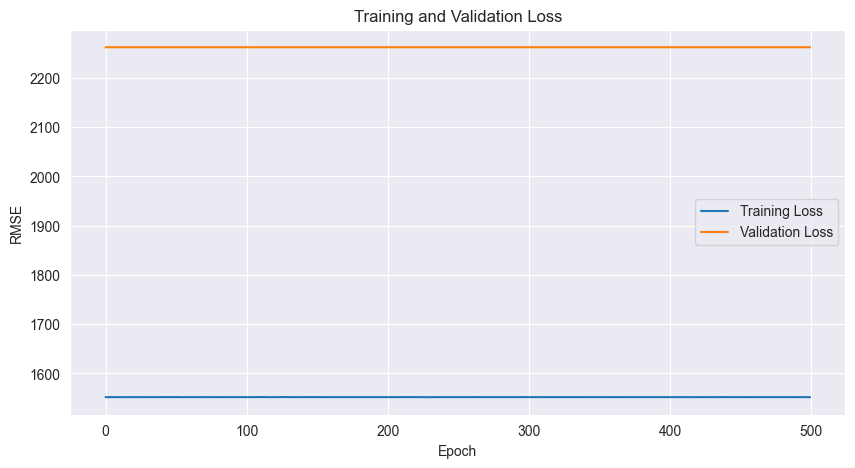

Final validation RMSE: 2262.3694
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 100.12it/s]


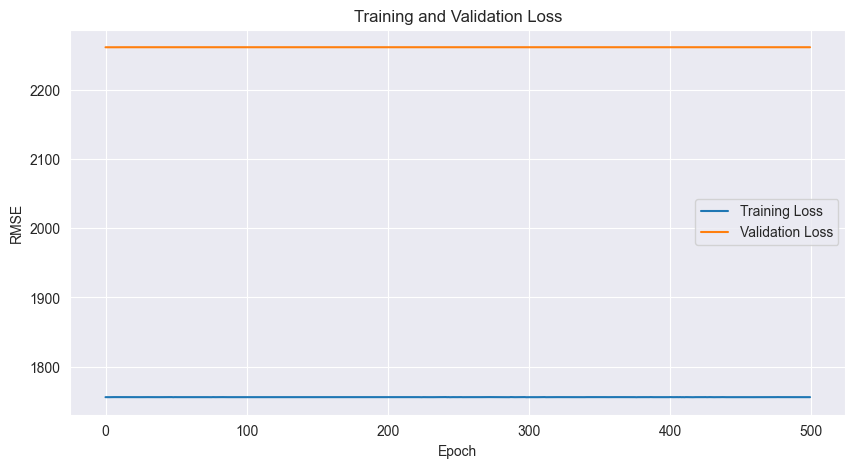

Final validation RMSE: 2261.7979
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 85.49it/s]


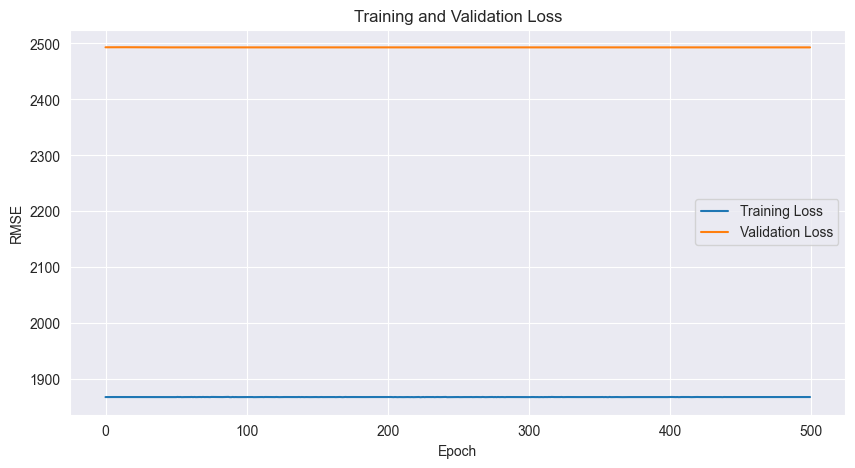

Final validation RMSE: 2493.0222
  Avg RMSE: 2032.3175 ± 417.8458

Testing: hidden_size=32, layers=10, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 151.16it/s]


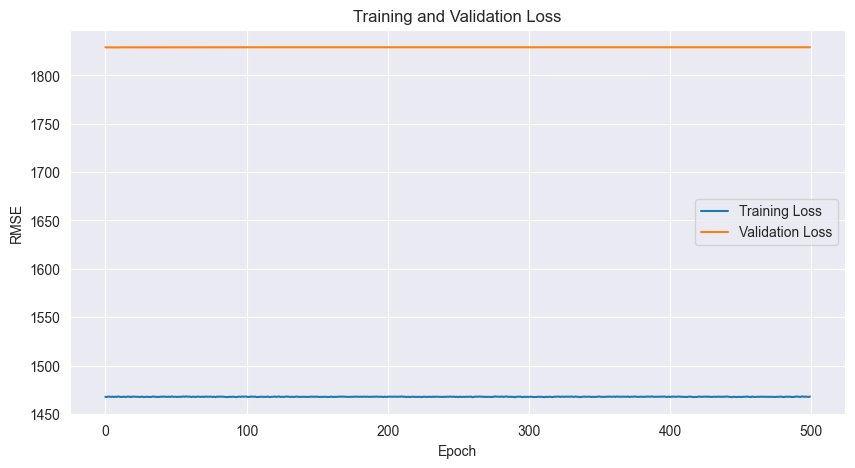

Final validation RMSE: 1828.8409
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 118.27it/s]


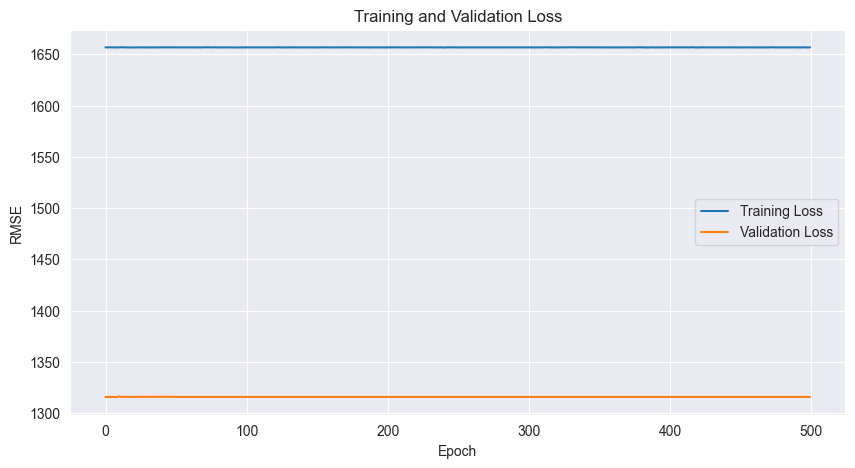

Final validation RMSE: 1315.3898
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 102.88it/s]


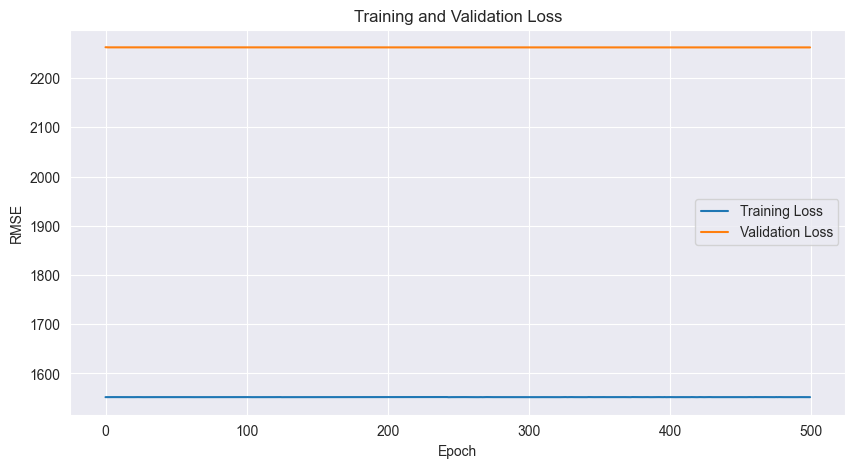

Final validation RMSE: 2262.2874
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 88.32it/s]


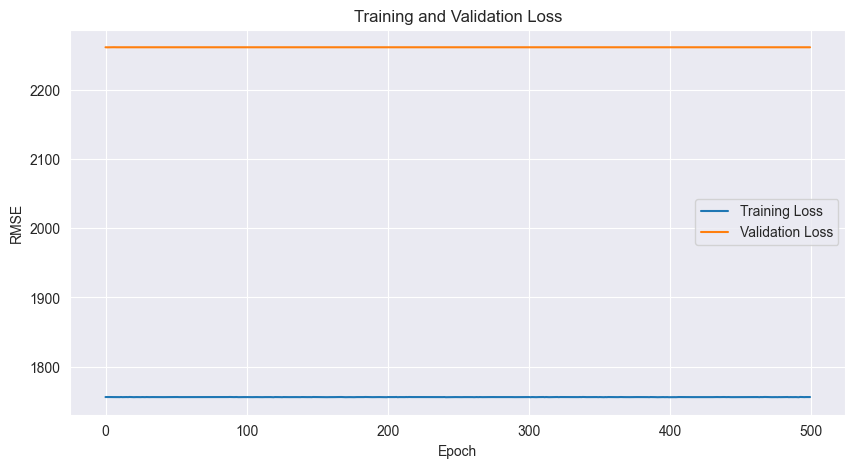

Final validation RMSE: 2261.6987
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 73.43it/s]


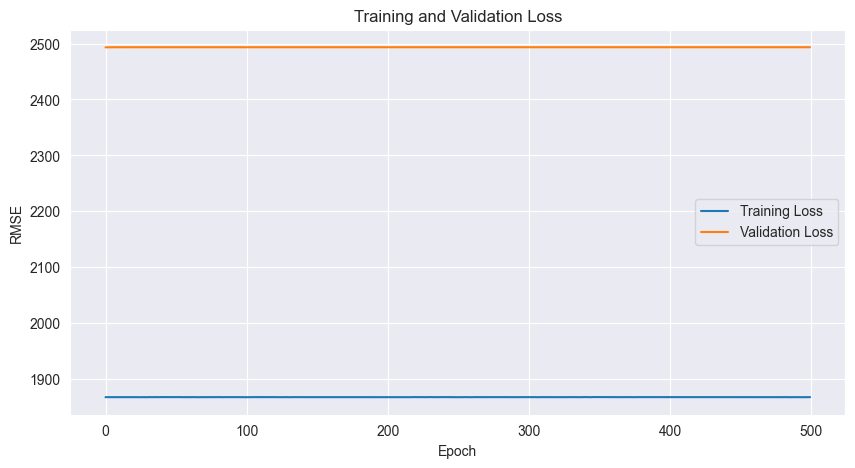

Final validation RMSE: 2493.2581
  Avg RMSE: 2032.2950 ± 417.9369

Testing: hidden_size=32, layers=10, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 137.51it/s]


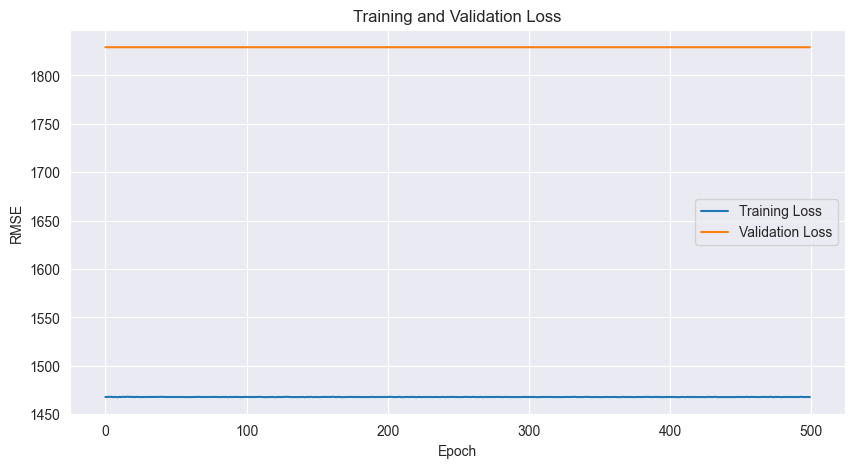

Final validation RMSE: 1828.9742
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 112.29it/s]


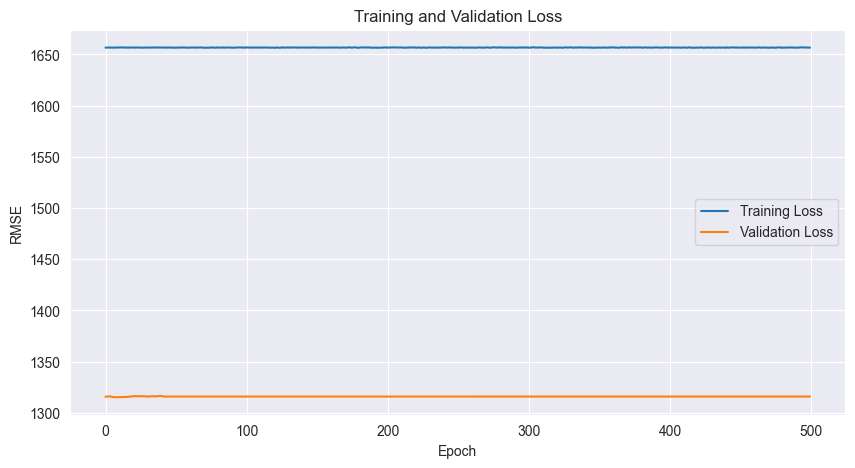

Final validation RMSE: 1315.1967
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 83.48it/s]


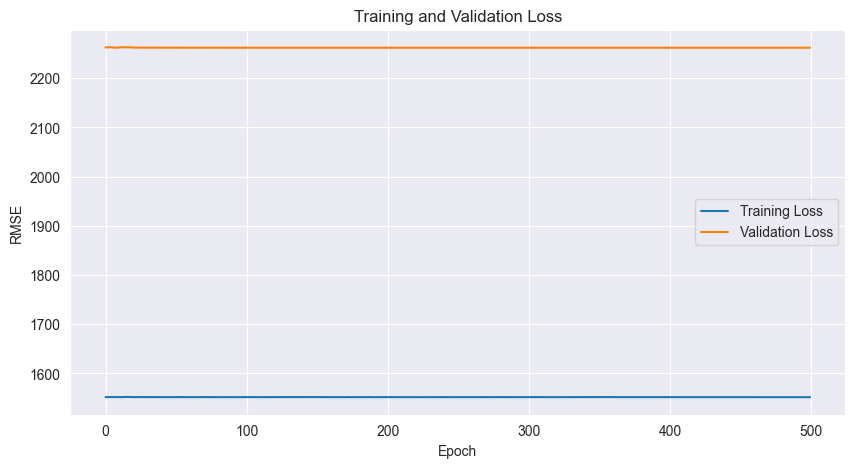

Final validation RMSE: 2261.8167
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 92.34it/s]


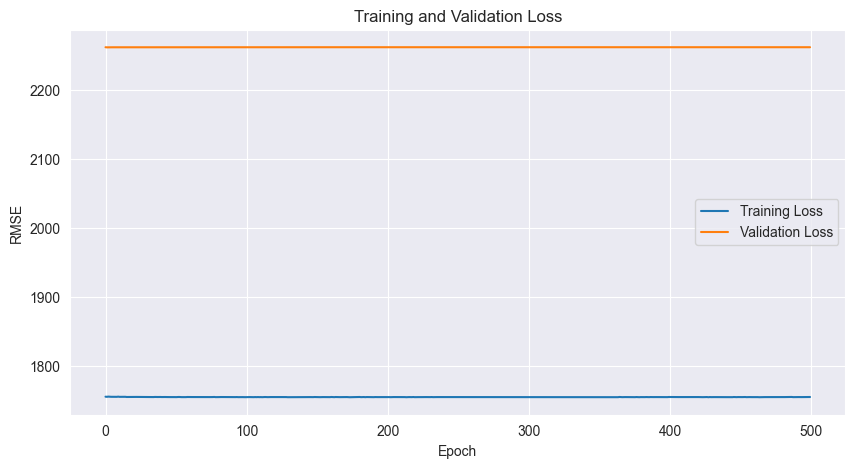

Final validation RMSE: 2261.7490
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 76.77it/s]


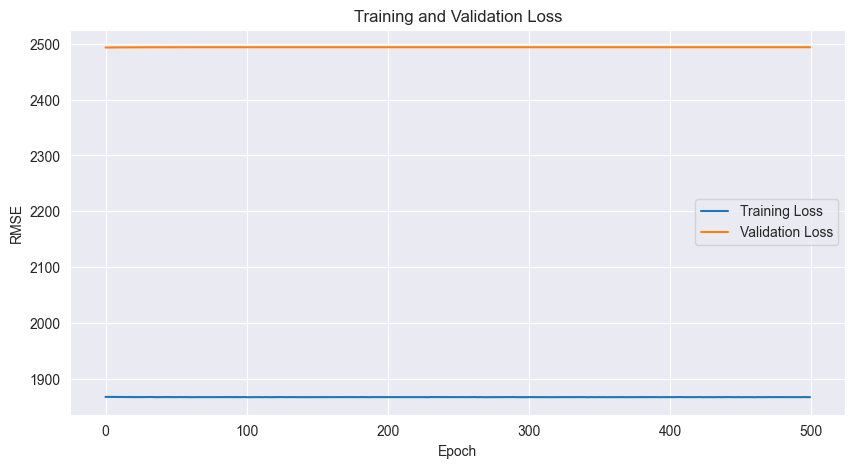

Final validation RMSE: 2493.2517
  Avg RMSE: 2032.1977 ± 417.9425

Testing: hidden_size=64, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 458.96it/s]


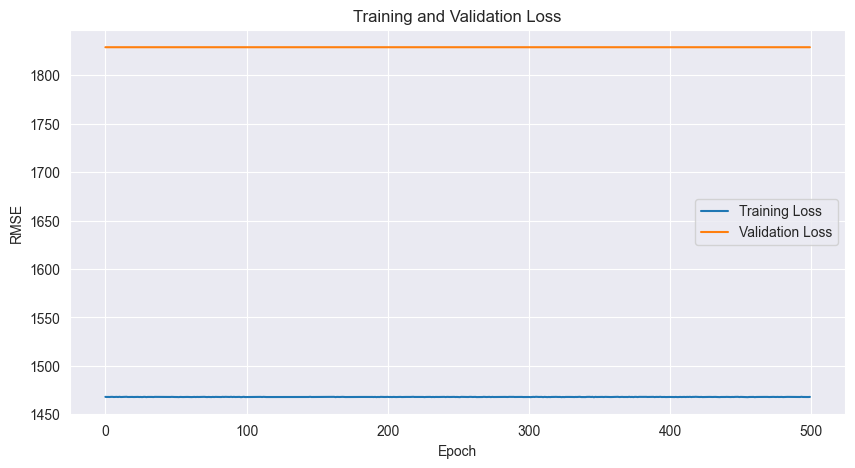

Final validation RMSE: 1829.0035
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 403.60it/s]


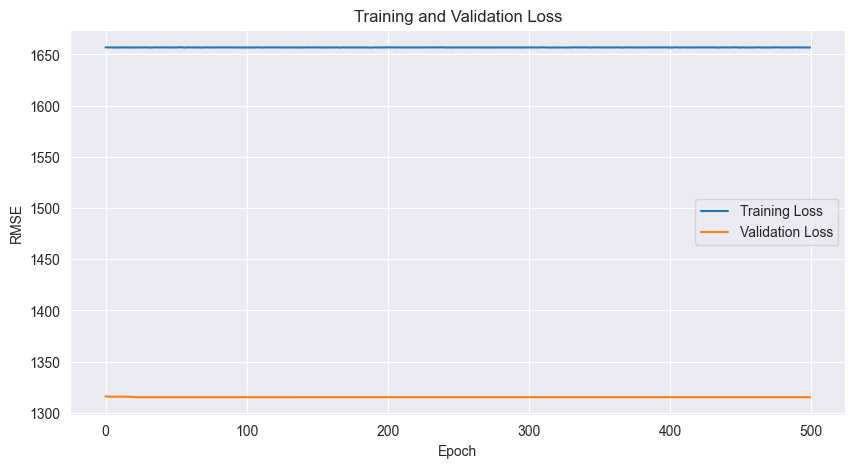

Final validation RMSE: 1315.1318
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 349.87it/s]


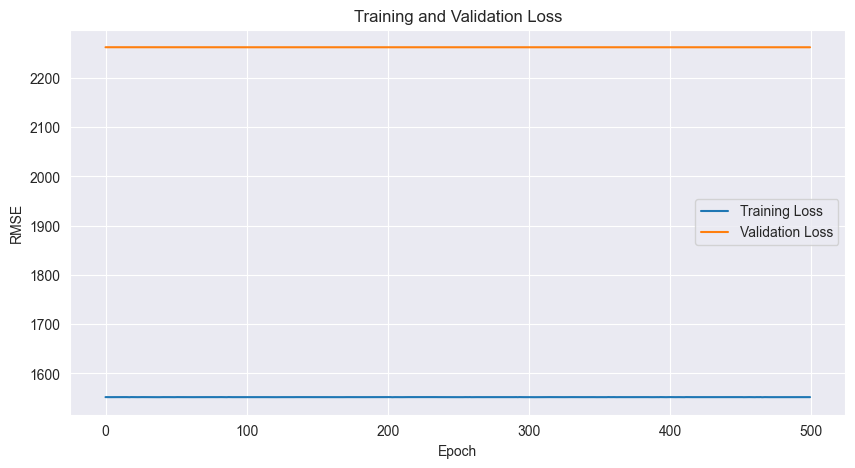

Final validation RMSE: 2262.3289
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 349.14it/s]


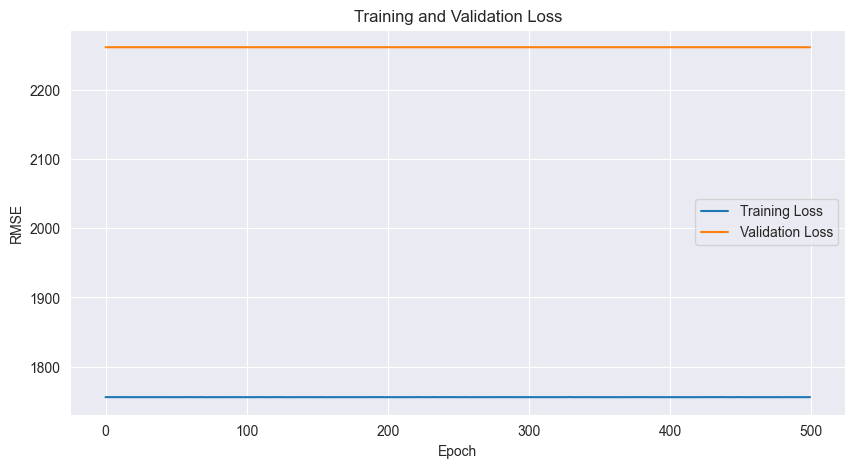

Final validation RMSE: 2261.7822
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 313.83it/s]


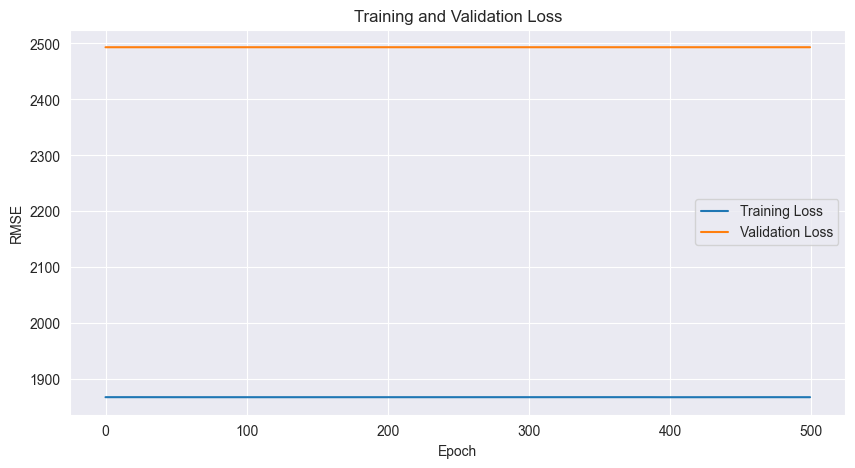

Final validation RMSE: 2493.1797
  Avg RMSE: 2032.2852 ± 418.0060

Testing: hidden_size=64, layers=2, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 413.77it/s]


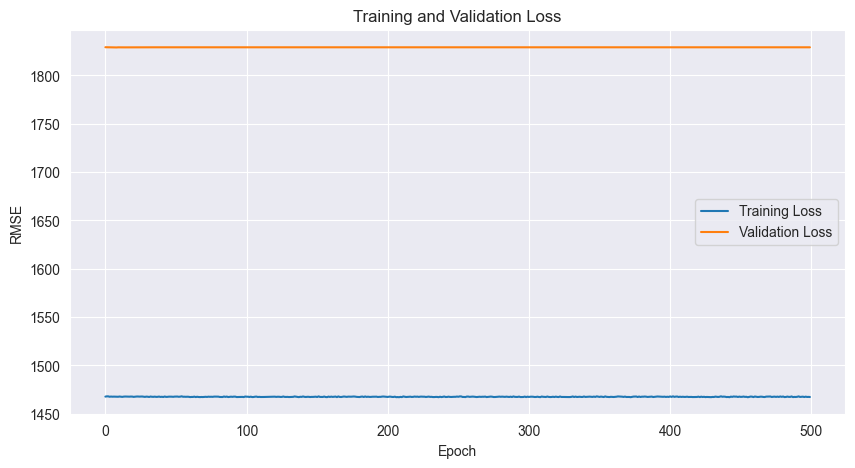

Final validation RMSE: 1828.8402
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 346.88it/s]


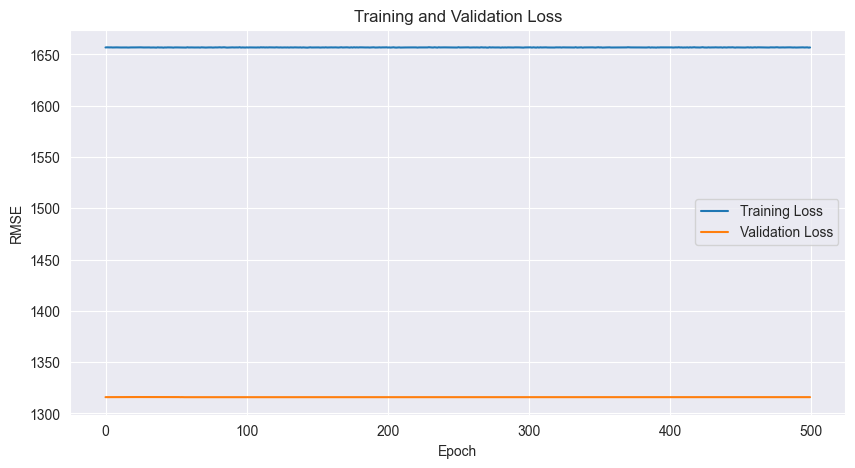

Final validation RMSE: 1315.7841
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 329.57it/s]


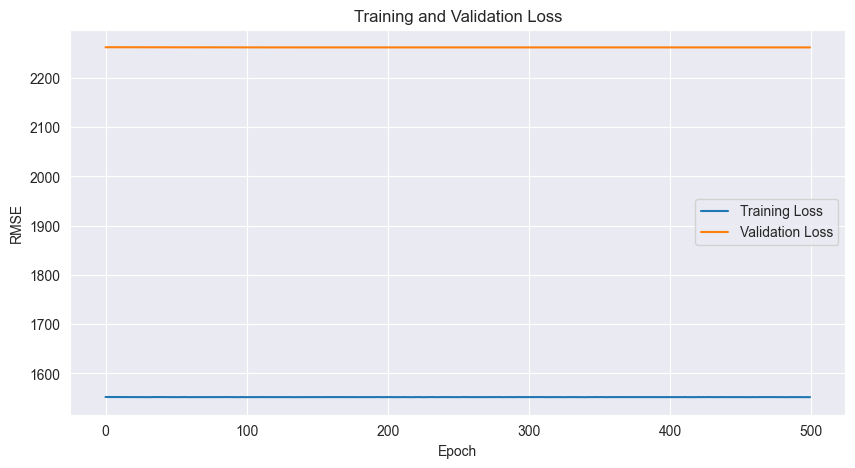

Final validation RMSE: 2261.8491
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 339.05it/s]


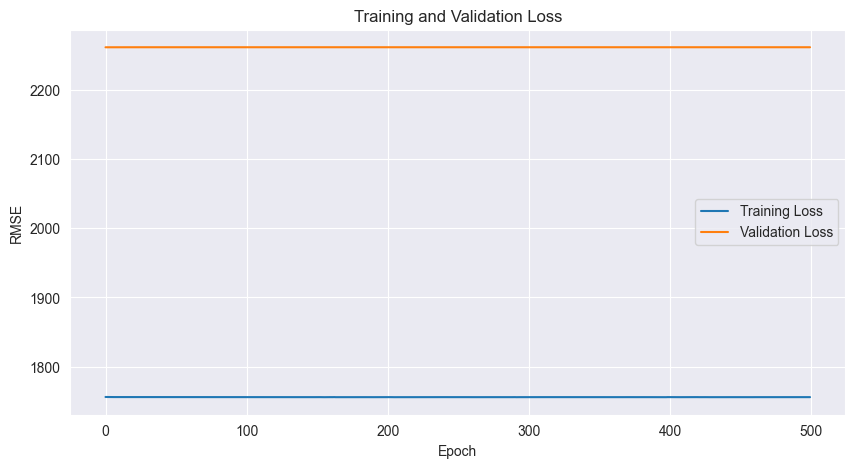

Final validation RMSE: 2261.7688
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 247.44it/s]


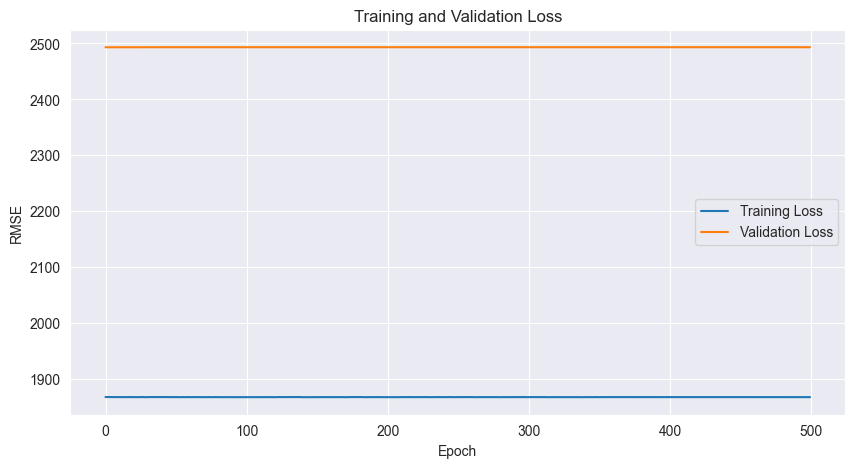

Final validation RMSE: 2493.1011
  Avg RMSE: 2032.2687 ± 417.7265

Testing: hidden_size=64, layers=2, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 458.17it/s]


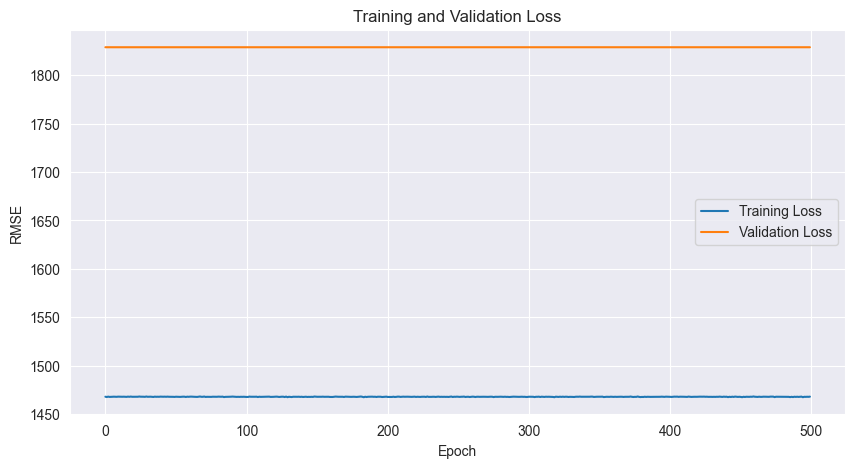

Final validation RMSE: 1828.9164
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 414.84it/s]


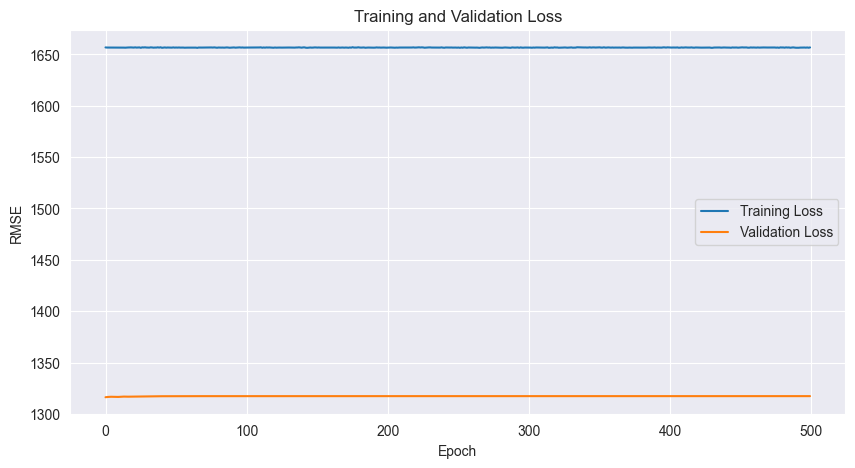

Final validation RMSE: 1316.2041
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 334.68it/s]


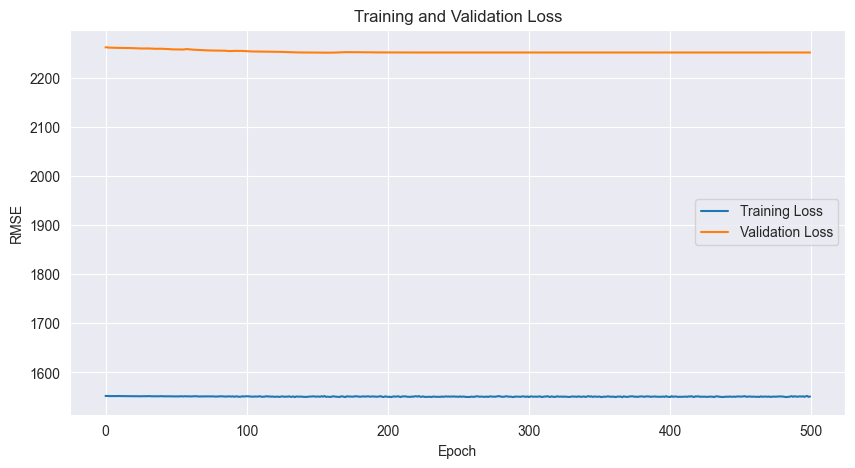

Final validation RMSE: 2251.0139
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 340.22it/s]


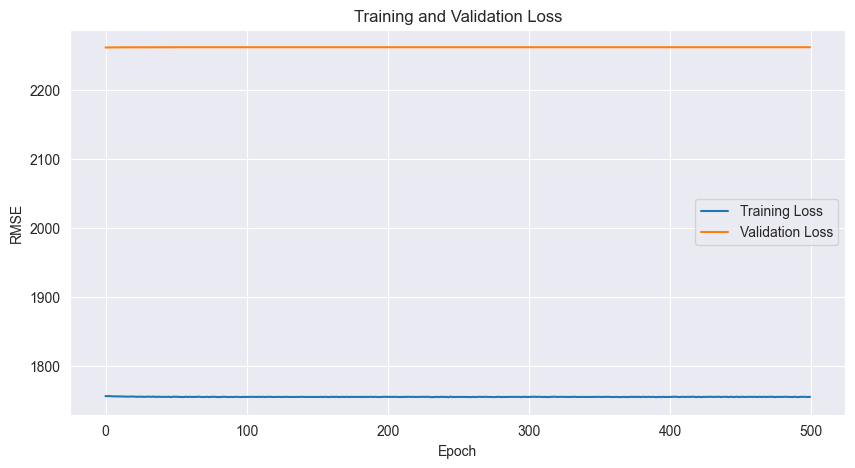

Final validation RMSE: 2261.7522
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 313.80it/s]


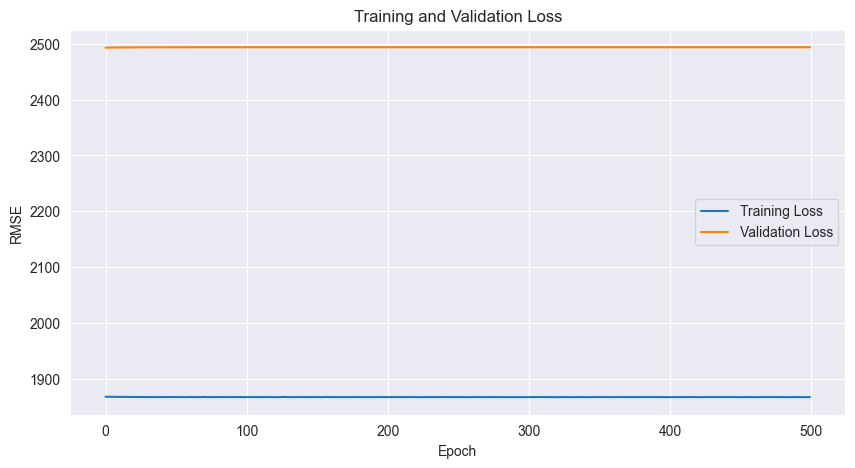

Final validation RMSE: 2493.0571
  Avg RMSE: 2030.1887 ± 416.3934
  New best model found!

Testing: hidden_size=64, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 214.30it/s]


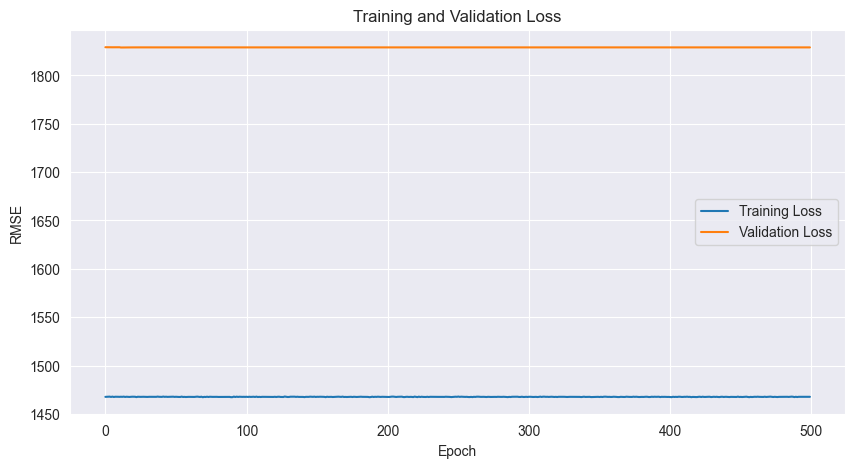

Final validation RMSE: 1828.7426
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 203.38it/s]


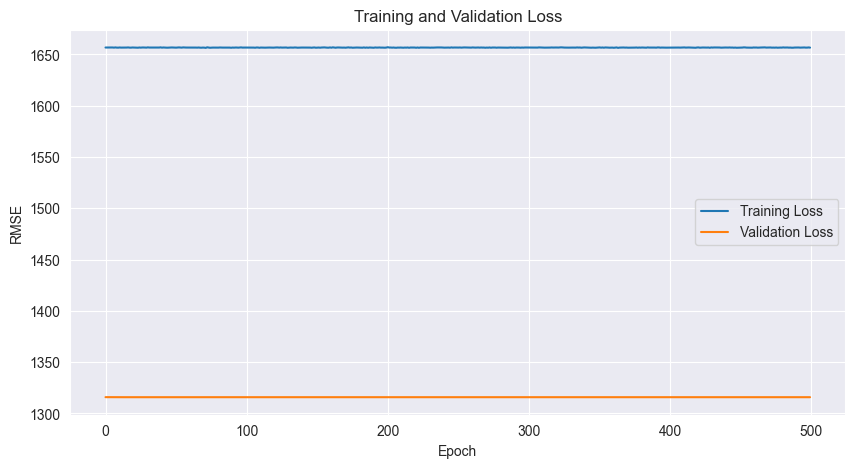

Final validation RMSE: 1315.7498
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 171.54it/s]


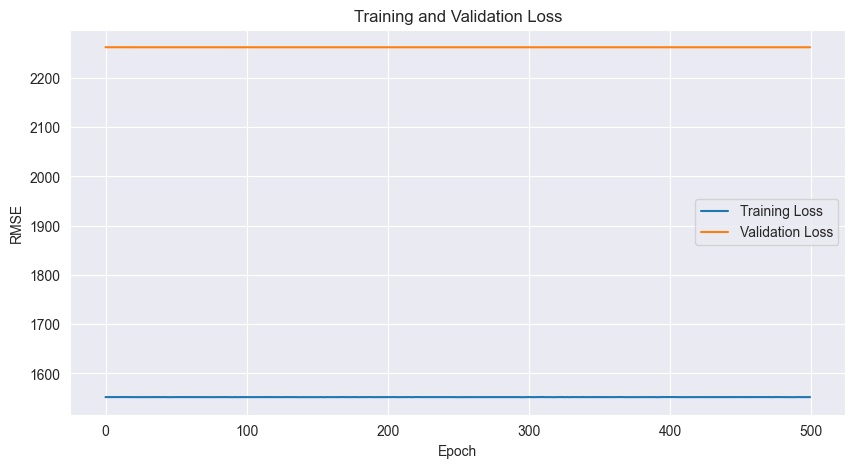

Final validation RMSE: 2262.0803
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 174.20it/s]


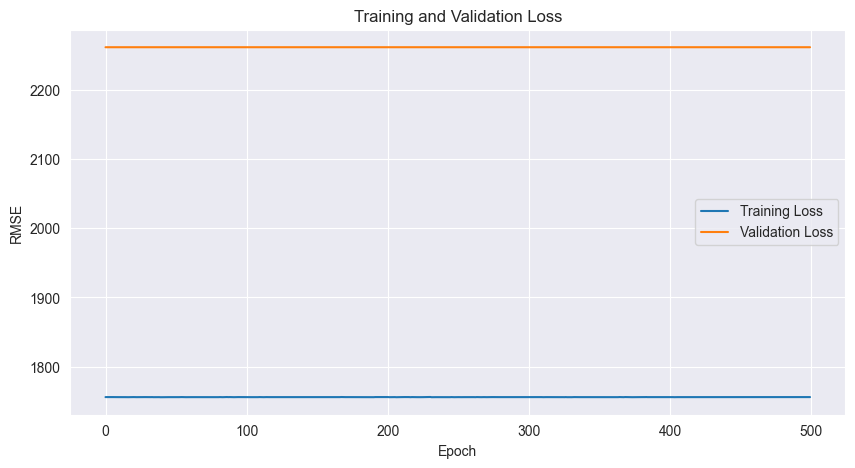

Final validation RMSE: 2261.8196
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 136.11it/s]


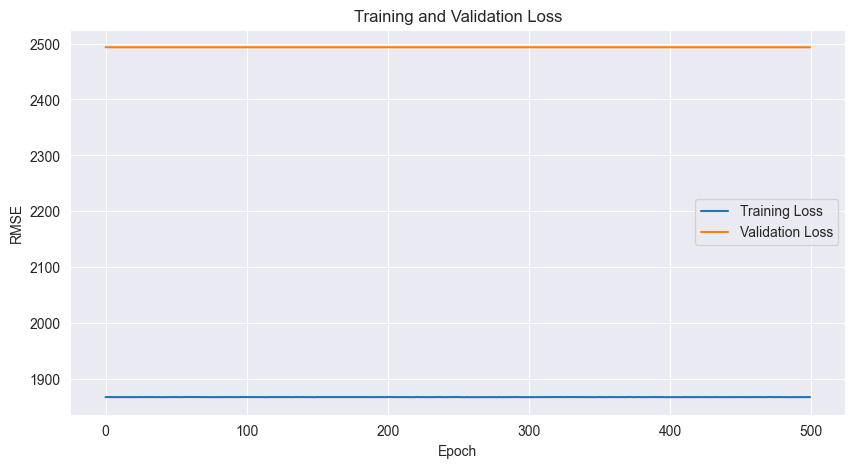

Final validation RMSE: 2493.3867
  Avg RMSE: 2032.3558 ± 417.8419

Testing: hidden_size=64, layers=5, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 238.54it/s]


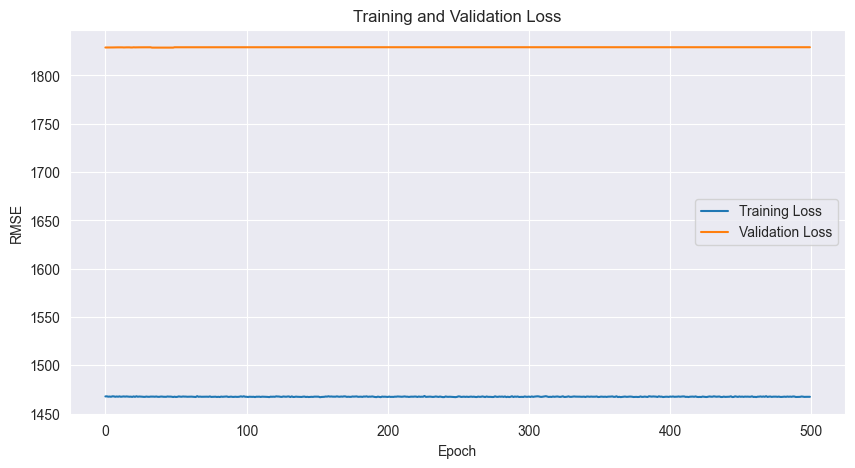

Final validation RMSE: 1828.8087
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 211.43it/s]


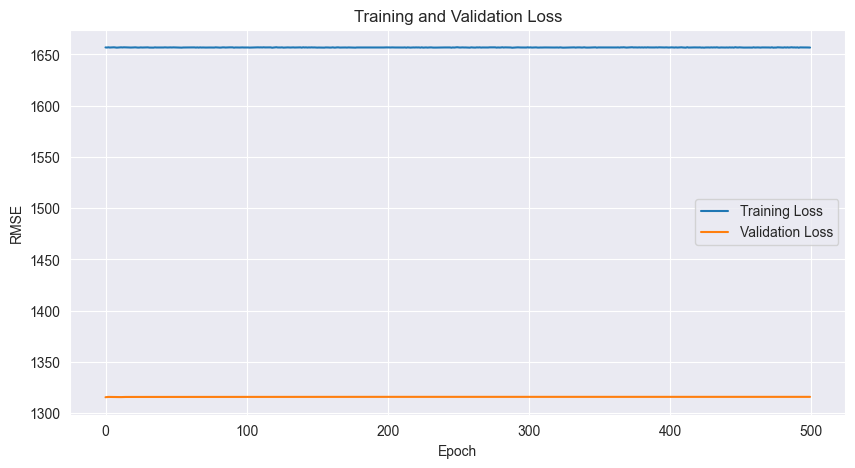

Final validation RMSE: 1315.6713
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 147.23it/s]


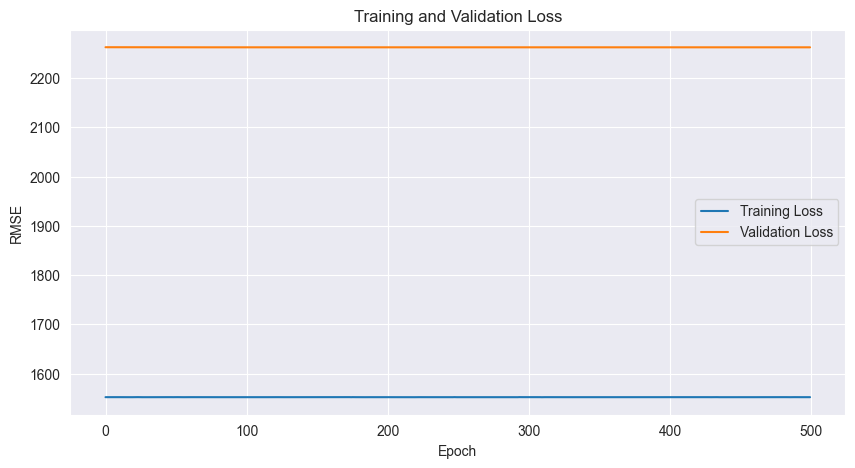

Final validation RMSE: 2262.2659
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 160.70it/s]


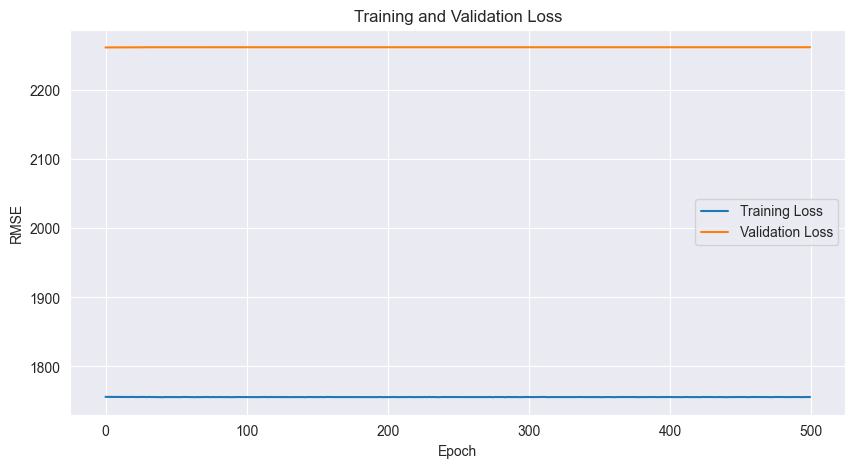

Final validation RMSE: 2261.6792
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 149.58it/s]


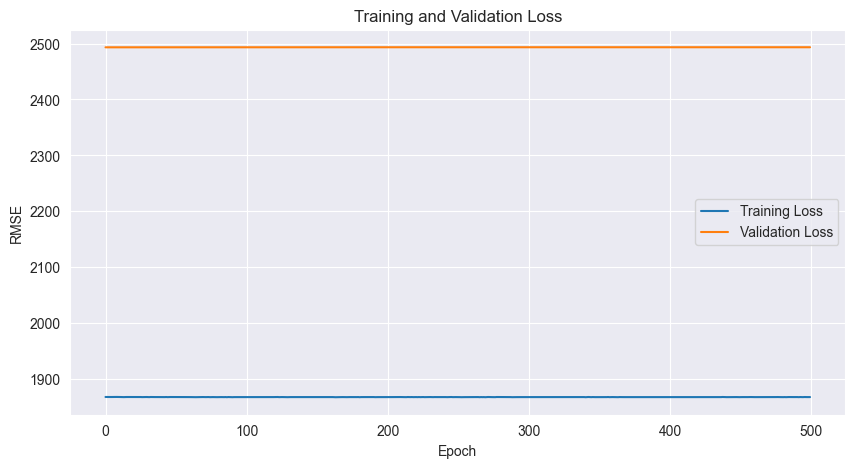

Final validation RMSE: 2493.2349
  Avg RMSE: 2032.3320 ± 417.8338

Testing: hidden_size=64, layers=5, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 246.69it/s]


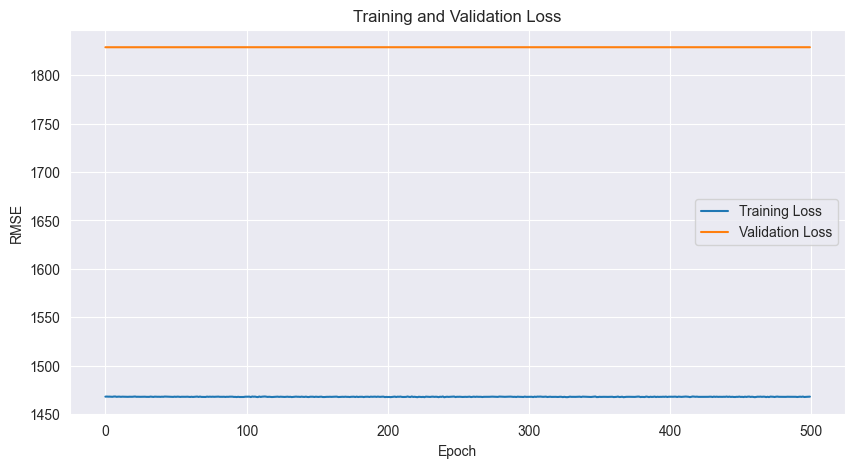

Final validation RMSE: 1828.9923
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 213.17it/s]


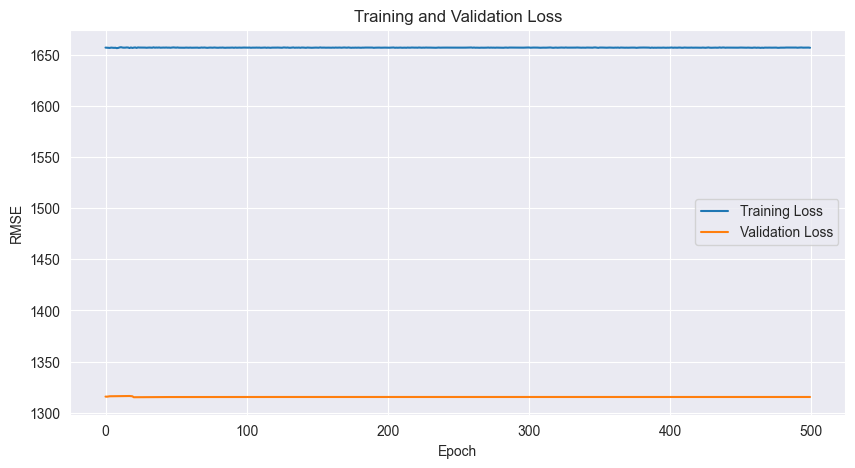

Final validation RMSE: 1315.1204
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 166.43it/s]


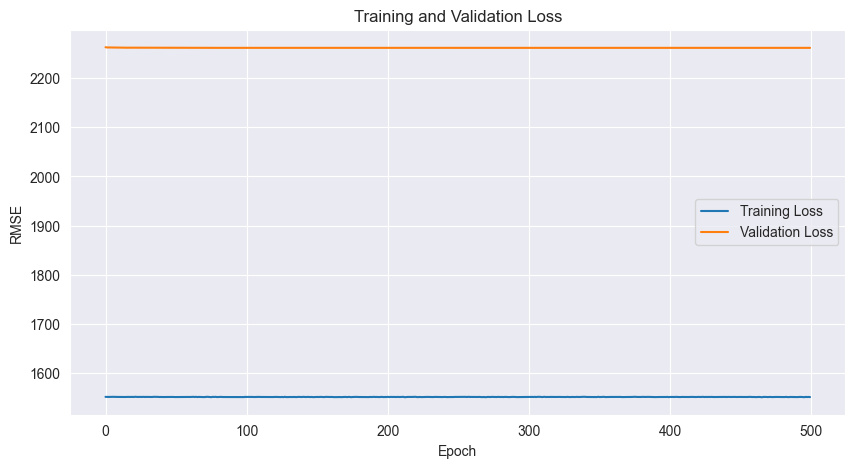

Final validation RMSE: 2261.0984
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 163.38it/s]


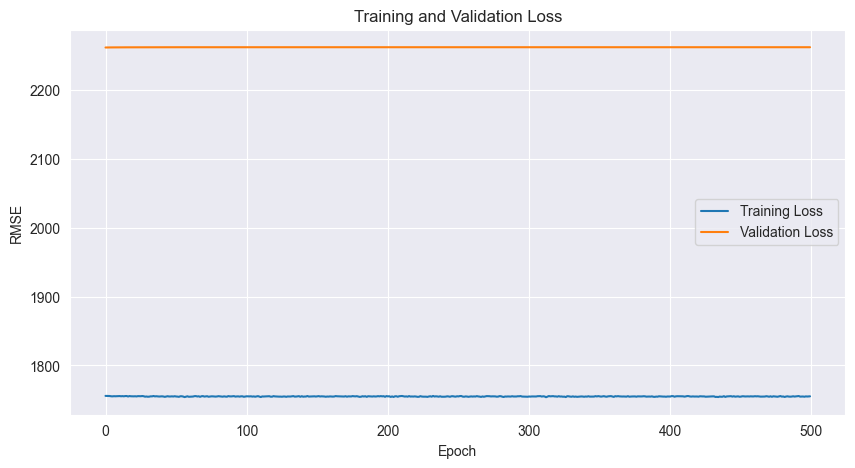

Final validation RMSE: 2261.8210
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 127.84it/s]


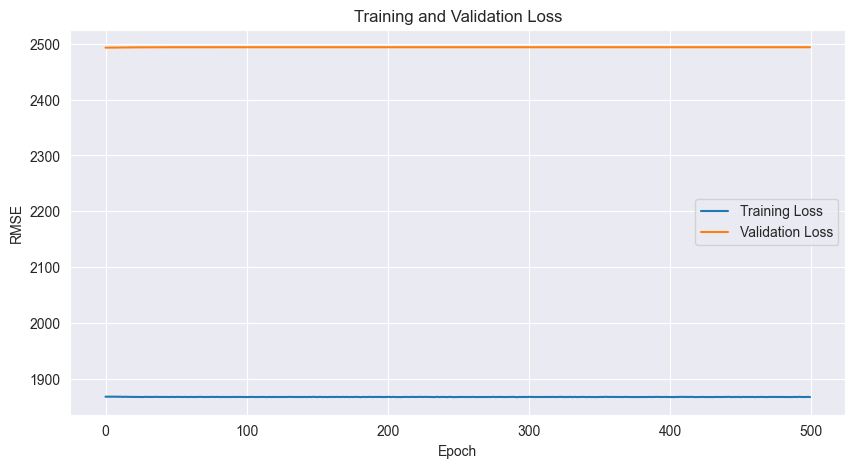

Final validation RMSE: 2493.2253
  Avg RMSE: 2032.0515 ± 417.8902

Testing: hidden_size=64, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 129.26it/s]


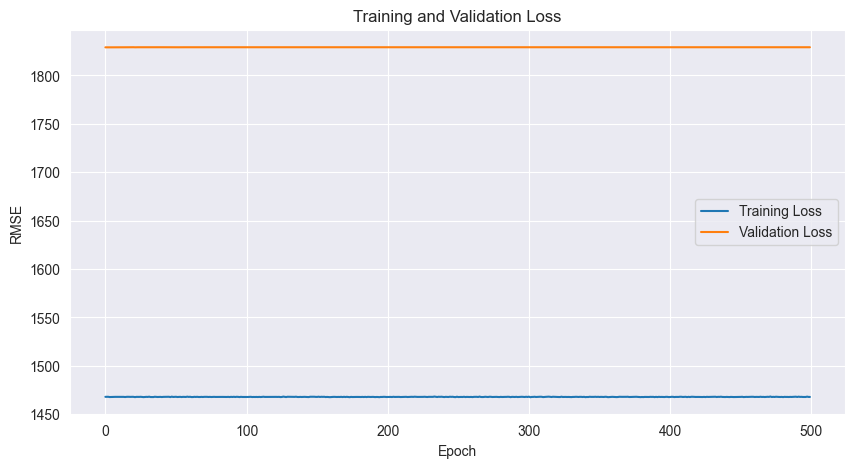

Final validation RMSE: 1828.9231
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 102.52it/s]


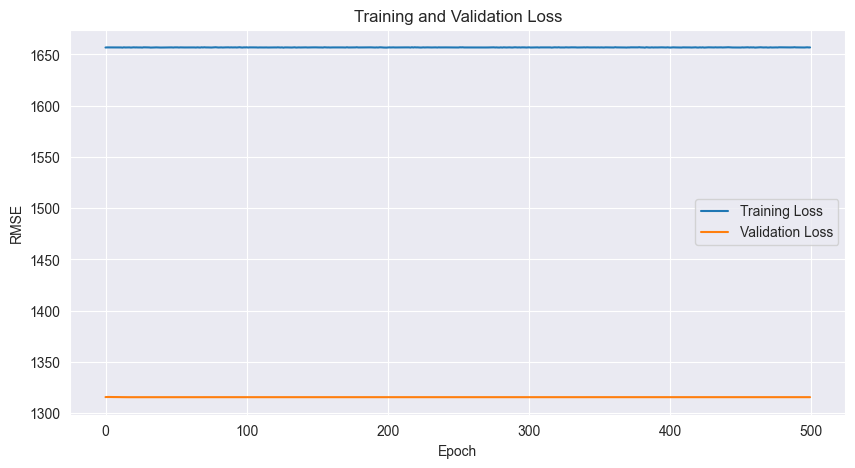

Final validation RMSE: 1315.6028
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 83.93it/s]


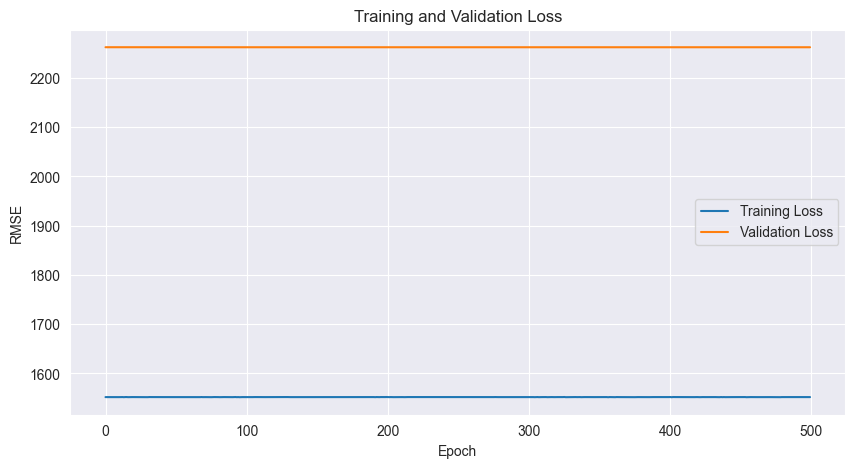

Final validation RMSE: 2262.1992
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 77.87it/s]


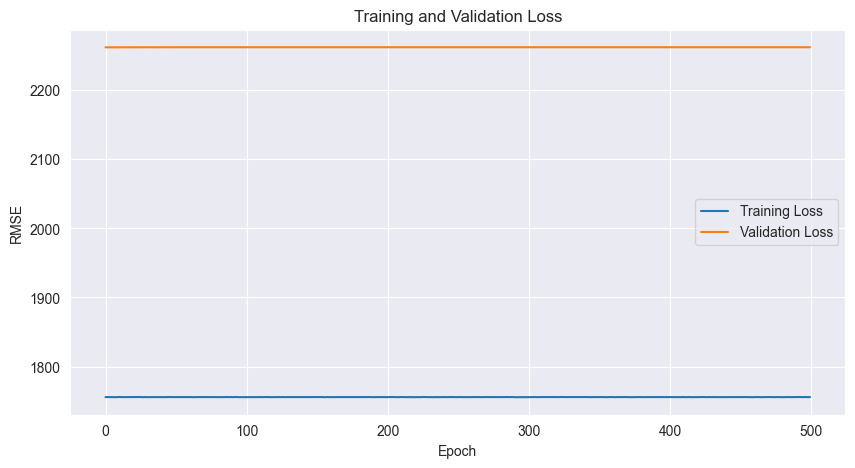

Final validation RMSE: 2261.7866
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 68.89it/s]


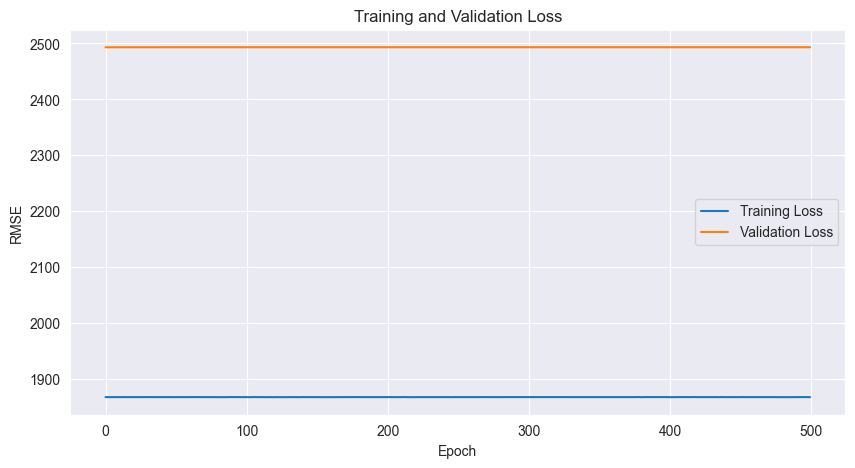

Final validation RMSE: 2493.0237
  Avg RMSE: 2032.3071 ± 417.8041

Testing: hidden_size=64, layers=10, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 126.38it/s]


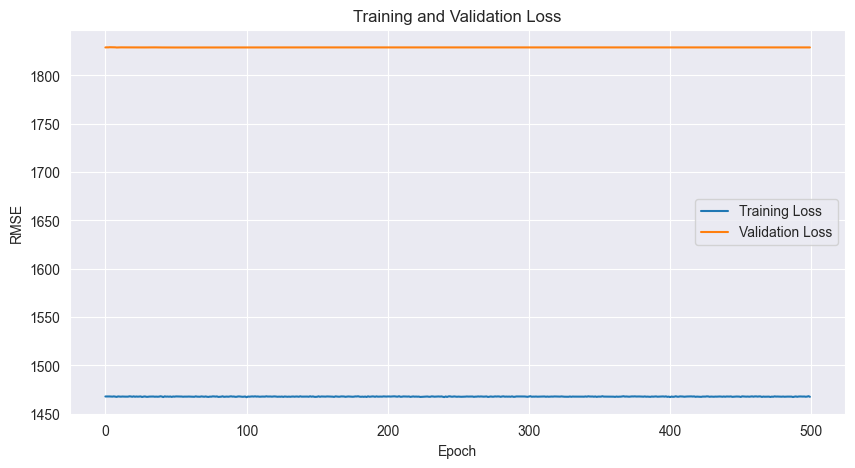

Final validation RMSE: 1828.8379
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 102.05it/s]


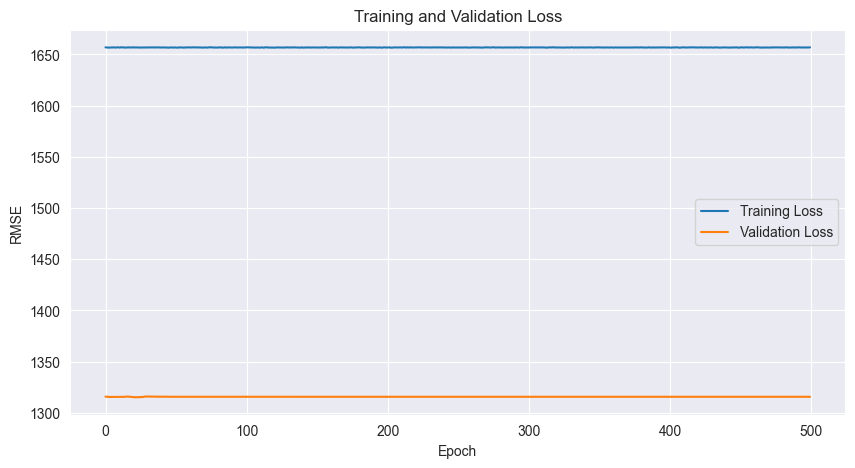

Final validation RMSE: 1315.3168
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 82.83it/s]


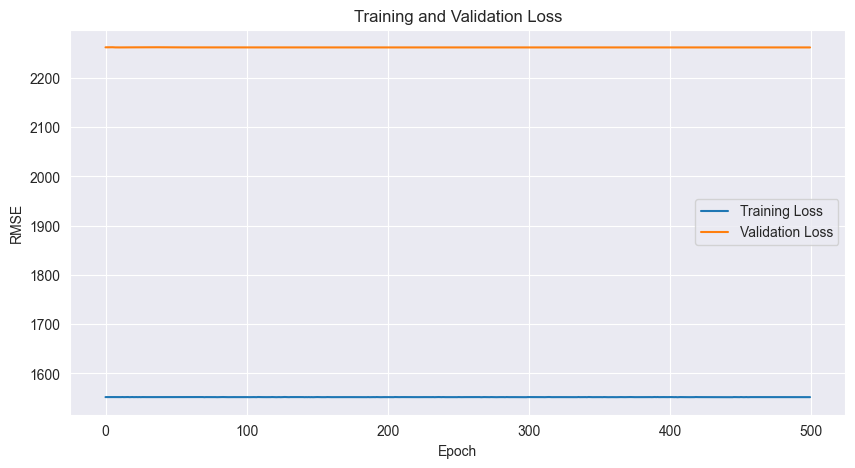

Final validation RMSE: 2261.9185
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 73.16it/s]


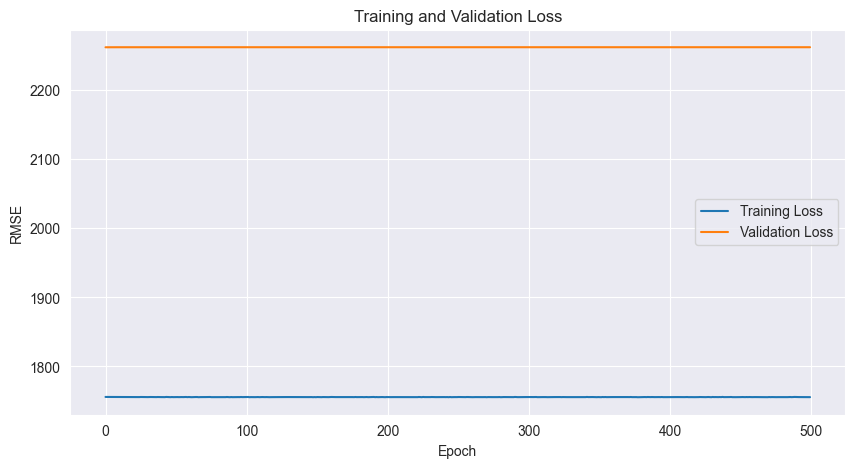

Final validation RMSE: 2261.7583
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 72.15it/s]


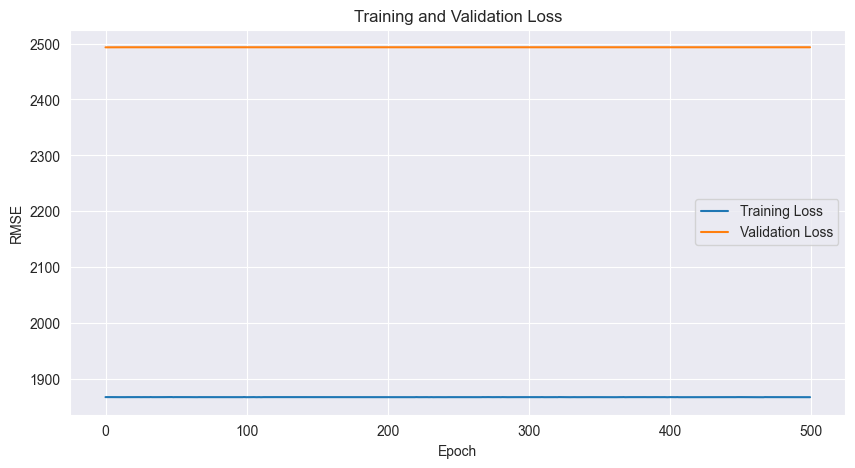

Final validation RMSE: 2493.2681
  Avg RMSE: 2032.2199 ± 417.9304

Testing: hidden_size=64, layers=10, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 136.23it/s]


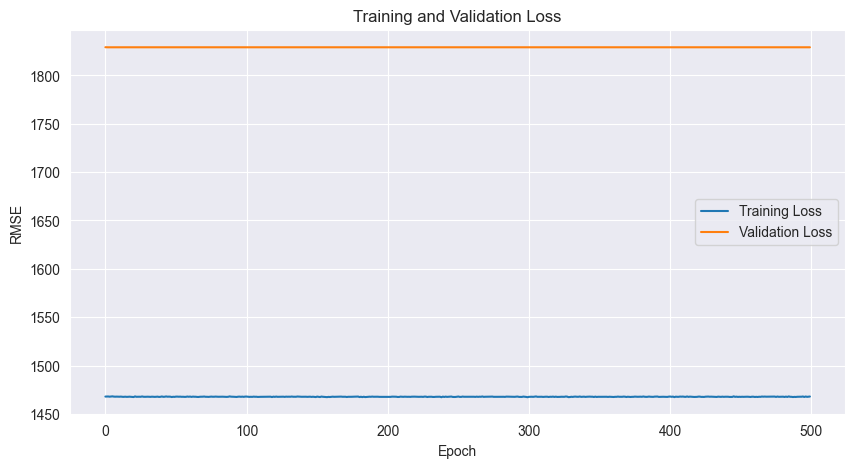

Final validation RMSE: 1828.9838
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 113.07it/s]


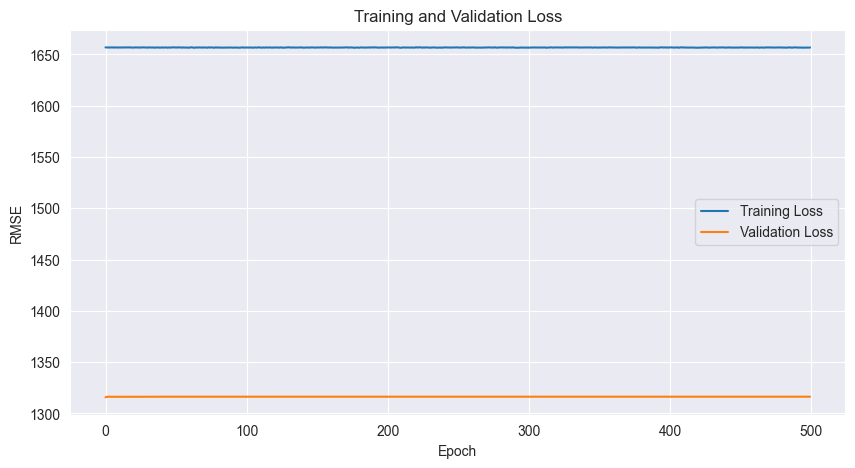

Final validation RMSE: 1315.7650
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 88.06it/s]


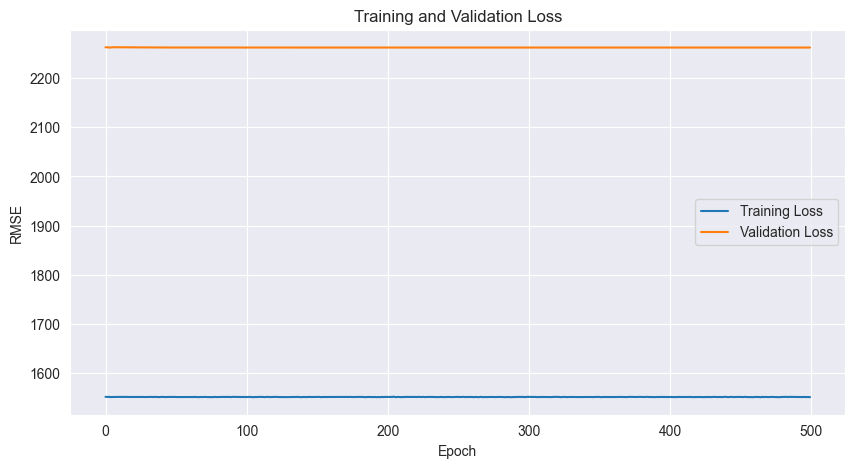

Final validation RMSE: 2261.5627
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 79.81it/s]


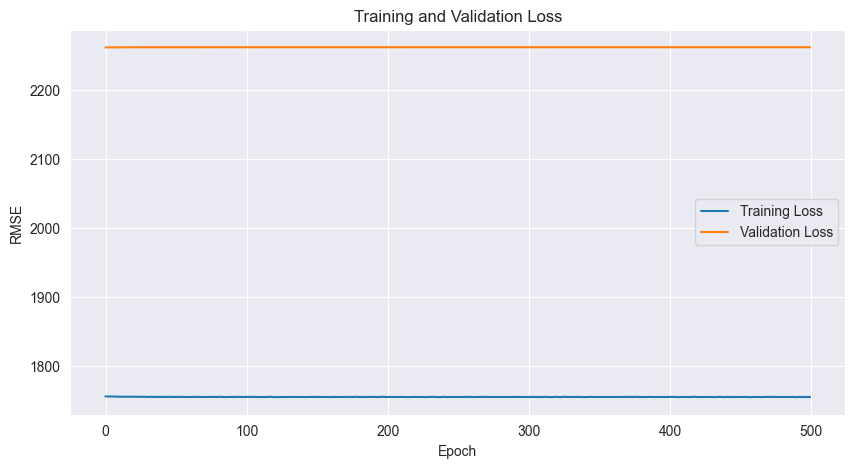

Final validation RMSE: 2261.7922
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 67.63it/s]


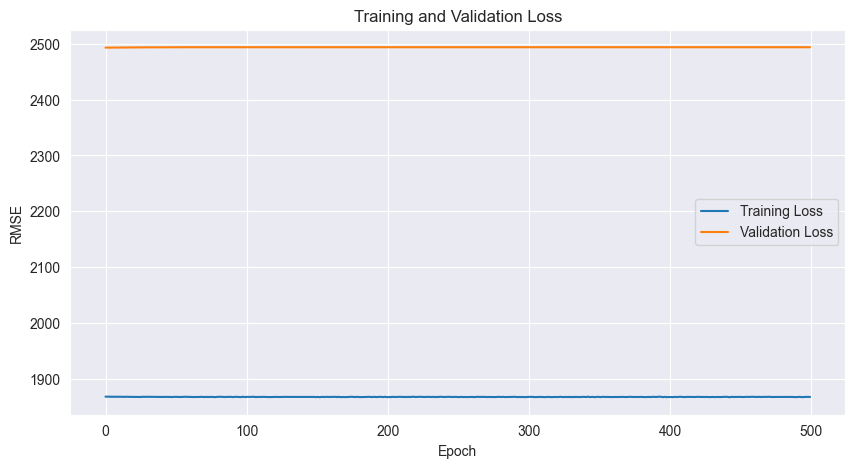

Final validation RMSE: 2493.2495
  Avg RMSE: 2032.2707 ± 417.7230

Testing: hidden_size=128, layers=2, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 370.08it/s]


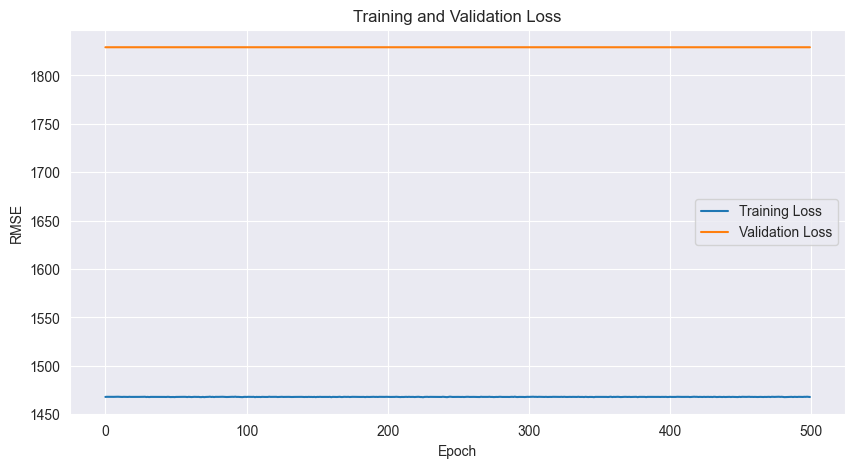

Final validation RMSE: 1828.9934
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 311.82it/s]


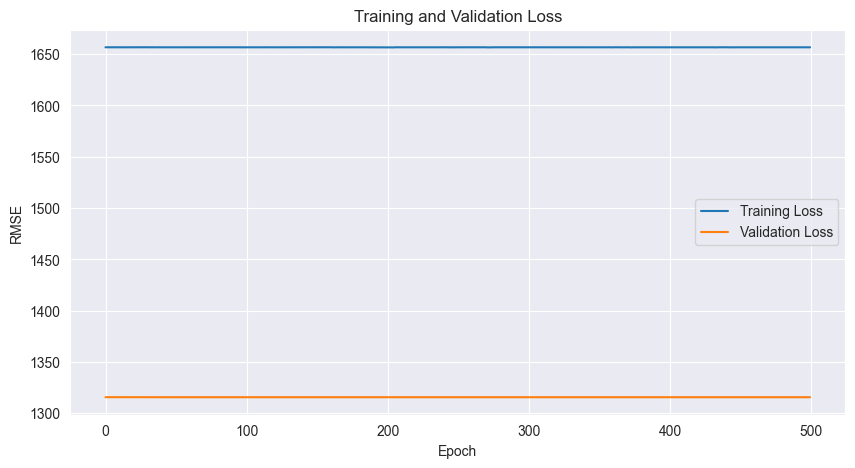

Final validation RMSE: 1315.6292
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 281.18it/s]


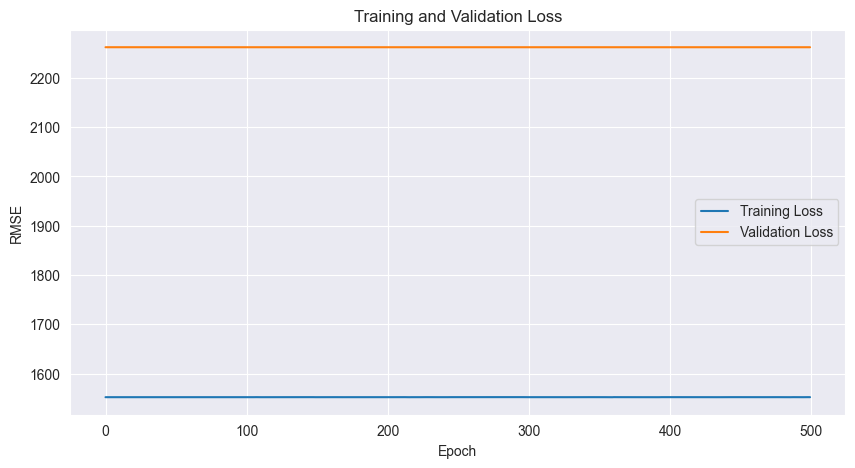

Final validation RMSE: 2262.3027
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 247.81it/s]


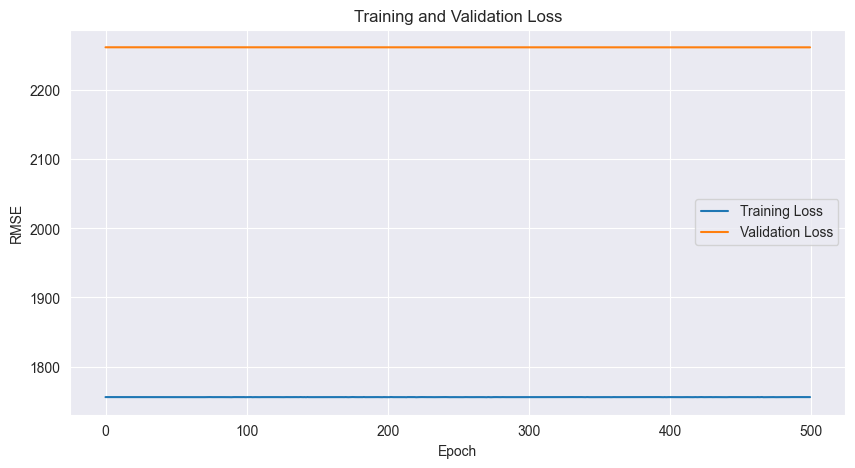

Final validation RMSE: 2261.6387
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 183.96it/s]


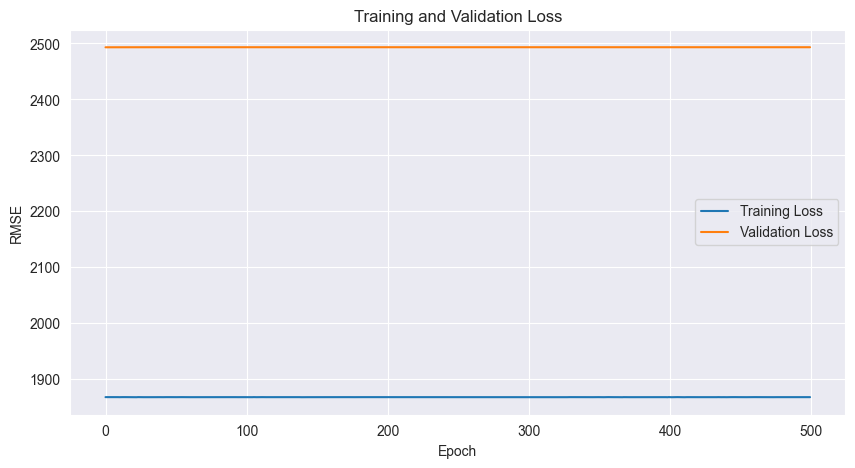

Final validation RMSE: 2493.1982
  Avg RMSE: 2032.3524 ± 417.8218

Testing: hidden_size=128, layers=2, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 349.41it/s]


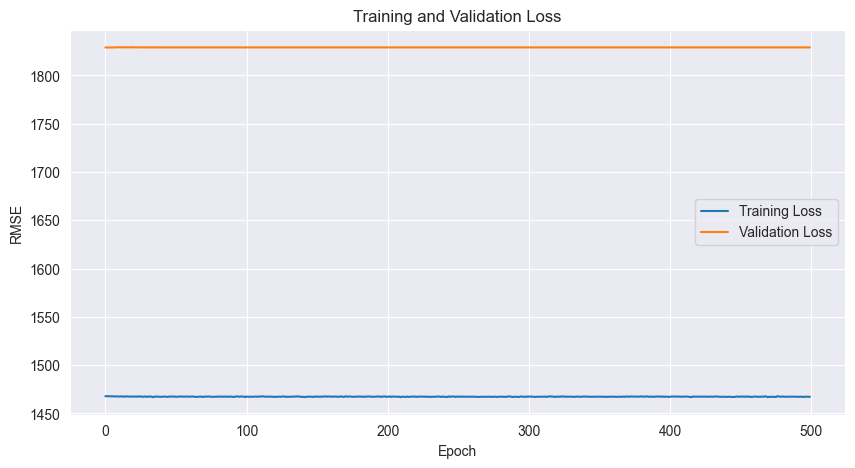

Final validation RMSE: 1828.9475
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 330.81it/s]


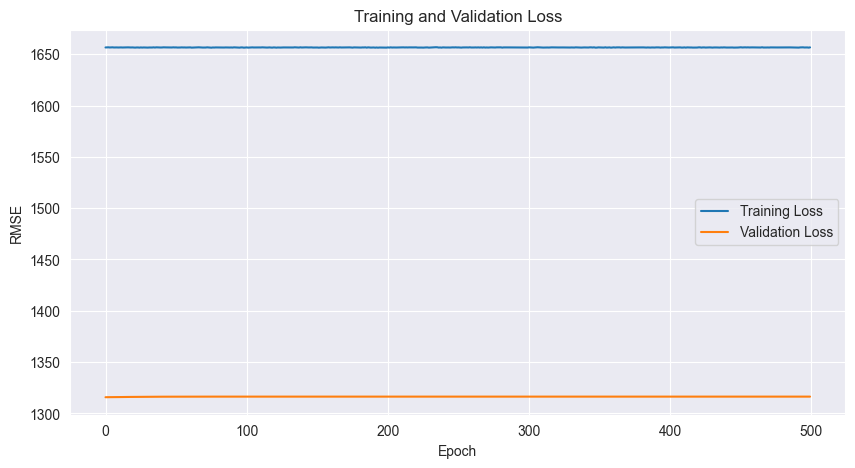

Final validation RMSE: 1315.7600
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 261.64it/s]


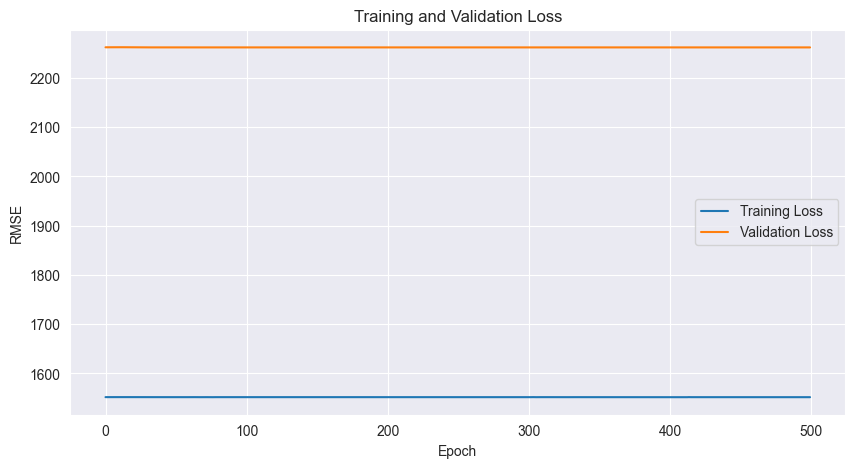

Final validation RMSE: 2262.0825
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 259.52it/s]


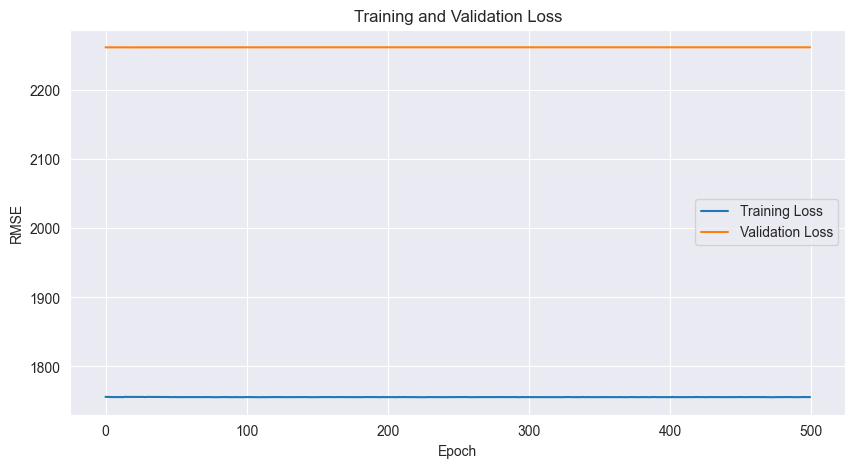

Final validation RMSE: 2261.7124
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 186.52it/s]


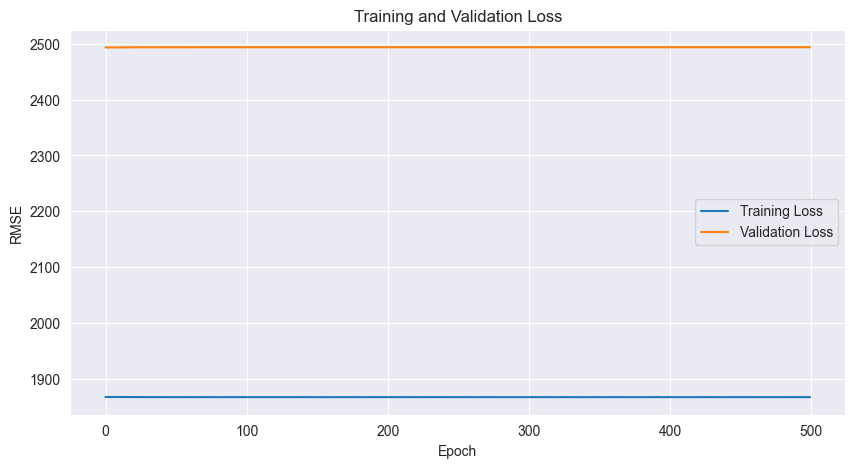

Final validation RMSE: 2493.1870
  Avg RMSE: 2032.3379 ± 417.7628

Testing: hidden_size=128, layers=2, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 397.25it/s]


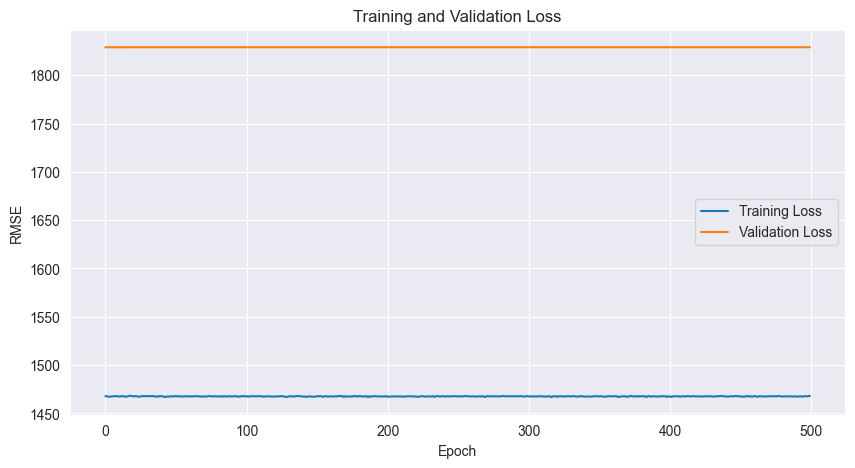

Final validation RMSE: 1828.9933
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 324.83it/s]


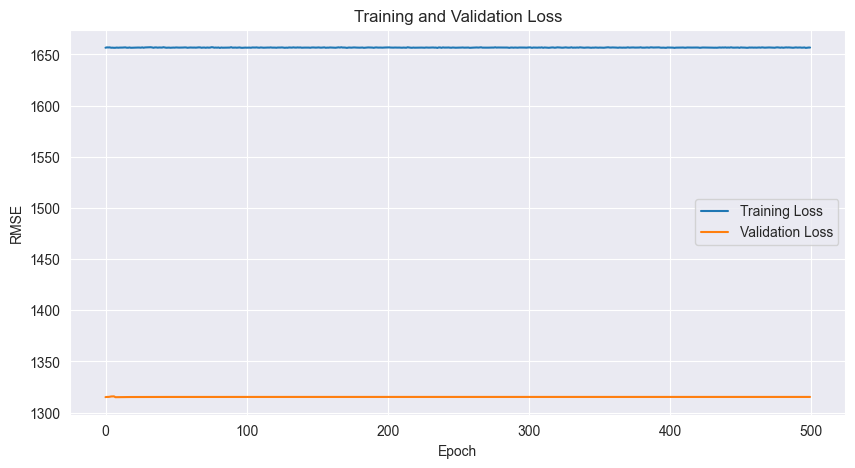

Final validation RMSE: 1315.0629
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 278.40it/s]


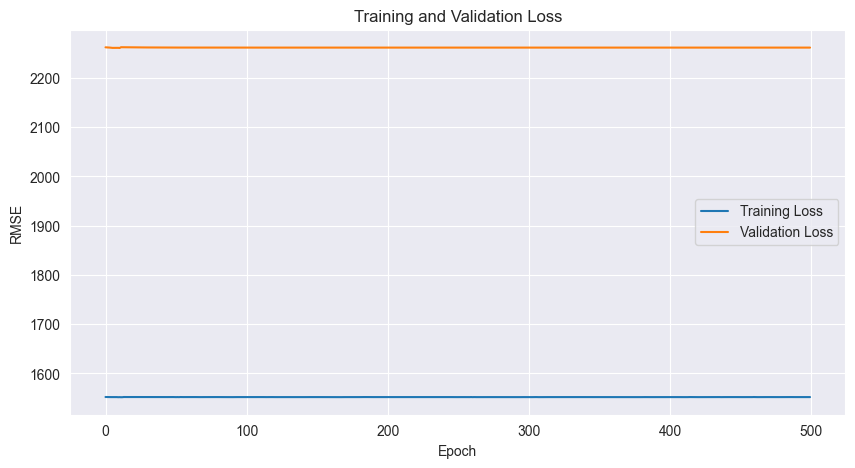

Final validation RMSE: 2260.9958
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:01<00:00, 262.18it/s]


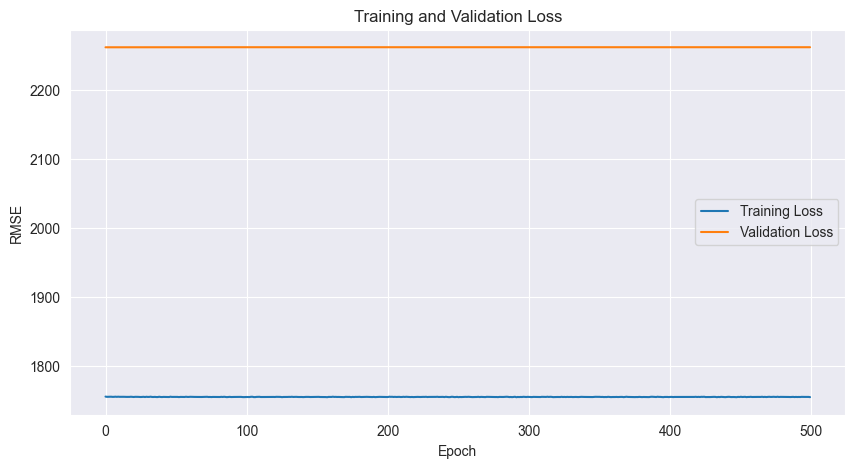

Final validation RMSE: 2261.8401
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 189.46it/s]


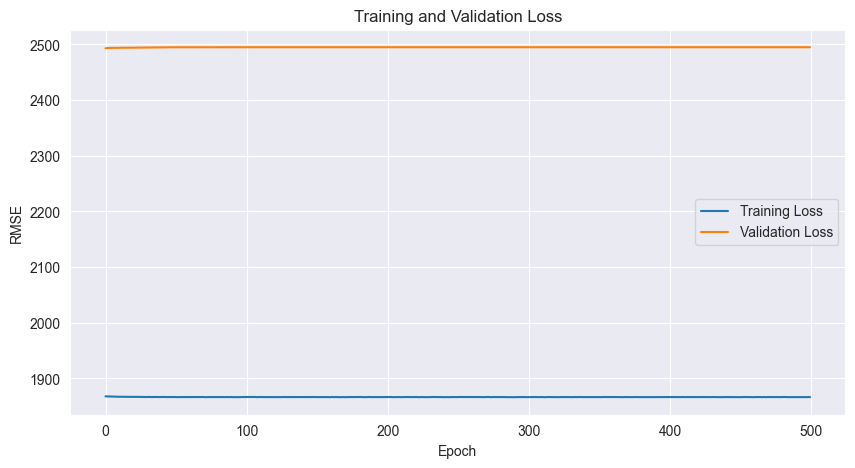

Final validation RMSE: 2493.1145
  Avg RMSE: 2032.0013 ± 417.8762

Testing: hidden_size=128, layers=5, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 190.59it/s]


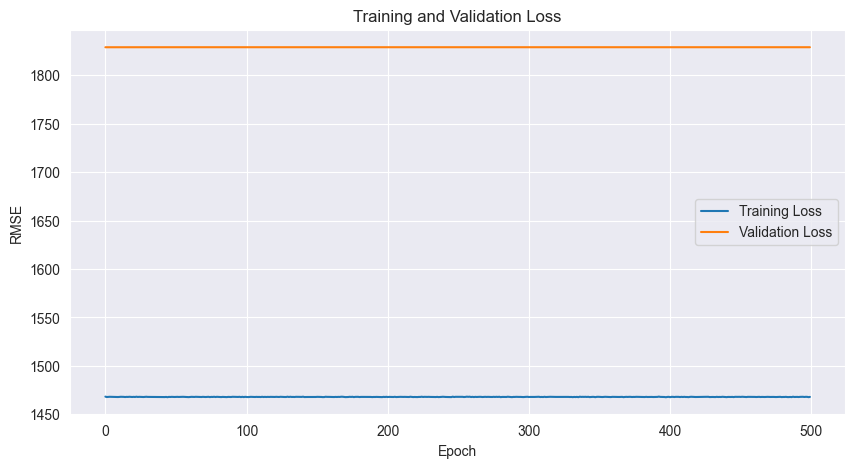

Final validation RMSE: 1828.9650
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 146.42it/s]


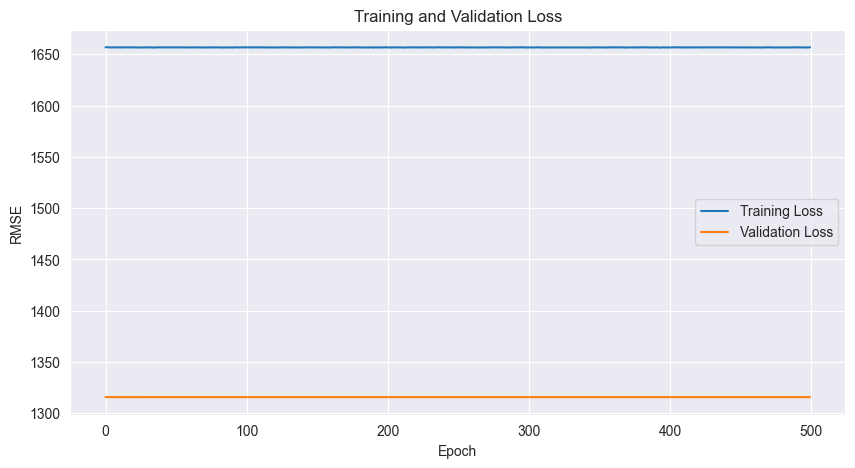

Final validation RMSE: 1315.6376
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 132.72it/s]


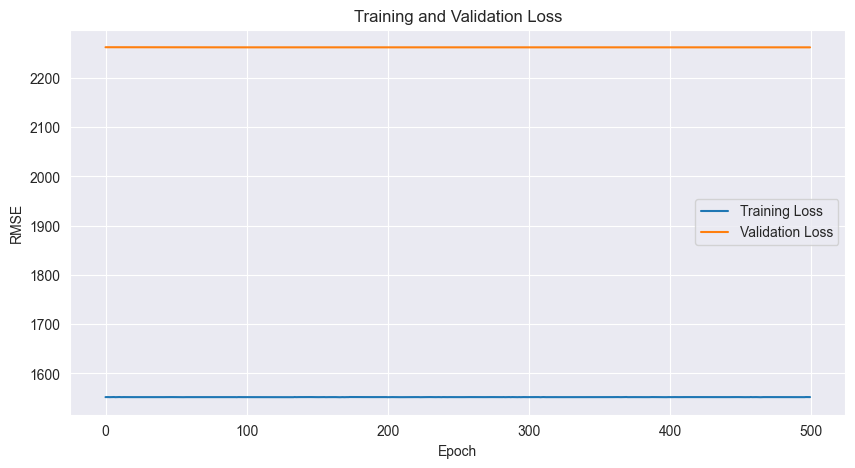

Final validation RMSE: 2261.8621
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 112.84it/s]


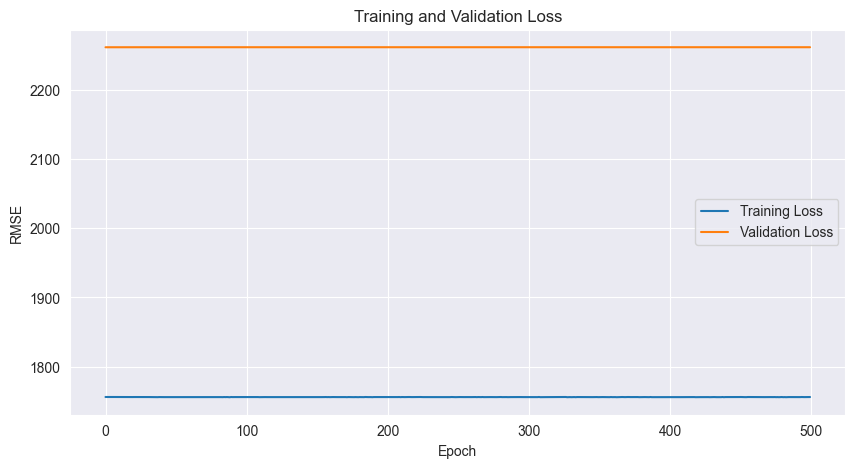

Final validation RMSE: 2261.7773
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 82.03it/s]


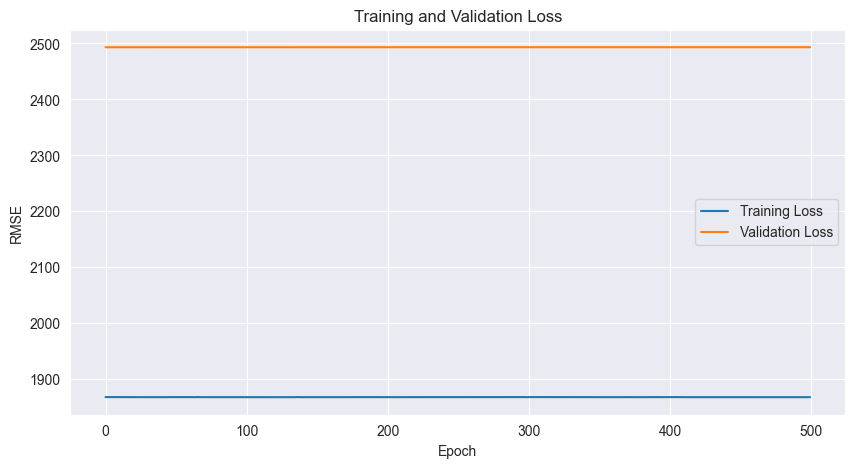

Final validation RMSE: 2493.2483
  Avg RMSE: 2032.2980 ± 417.7995

Testing: hidden_size=128, layers=5, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 185.00it/s]


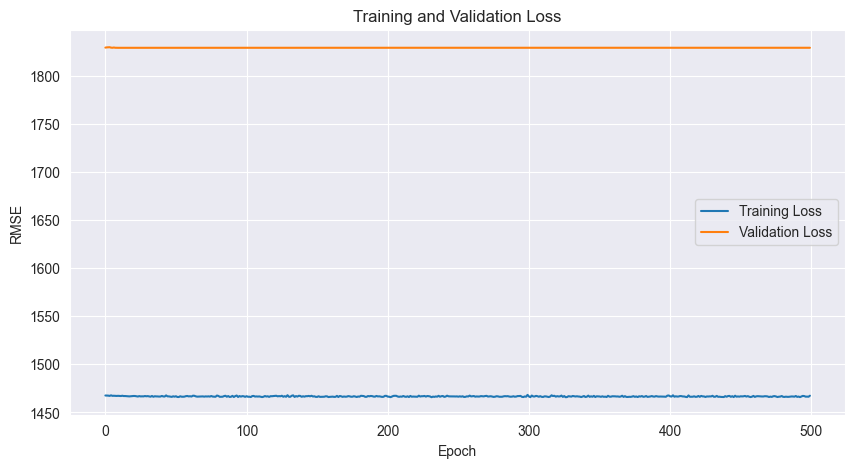

Final validation RMSE: 1828.9835
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 155.12it/s]


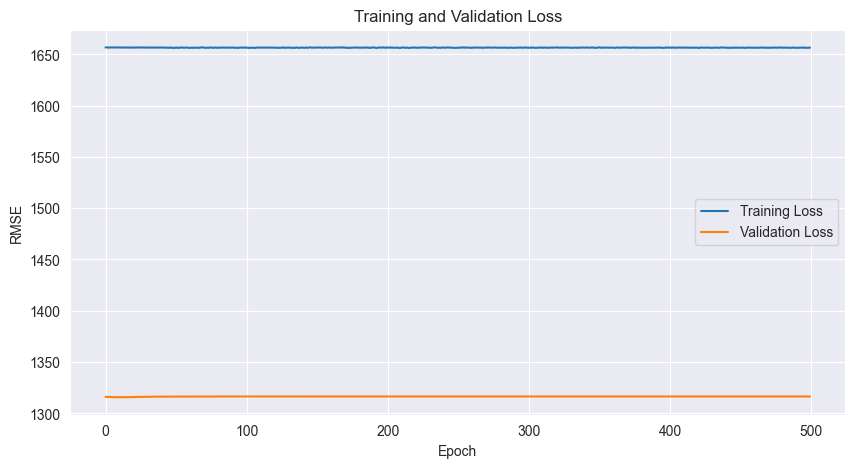

Final validation RMSE: 1315.7112
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 111.92it/s]


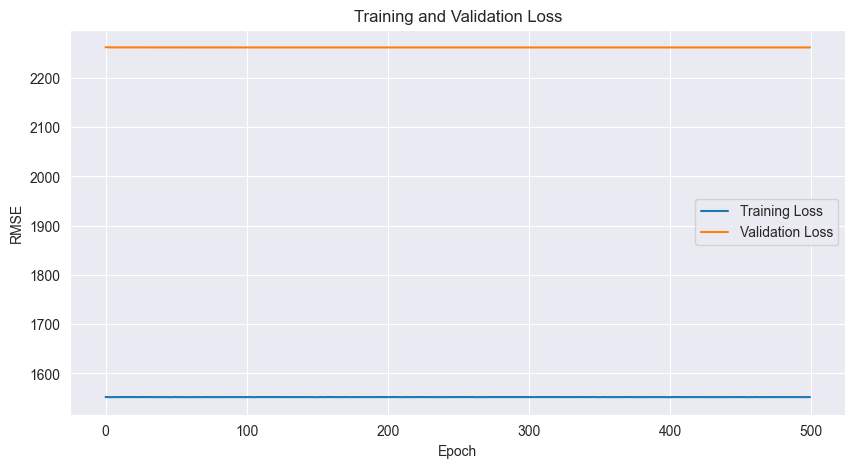

Final validation RMSE: 2261.8840
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 113.60it/s]


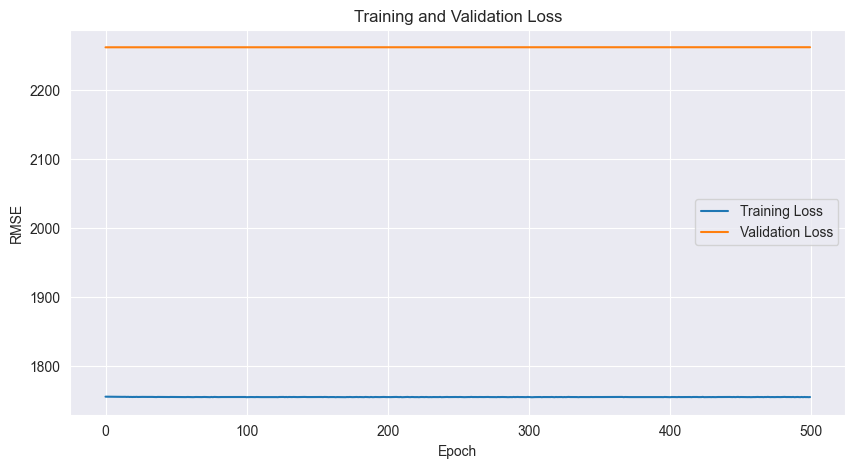

Final validation RMSE: 2261.8083
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 84.47it/s]


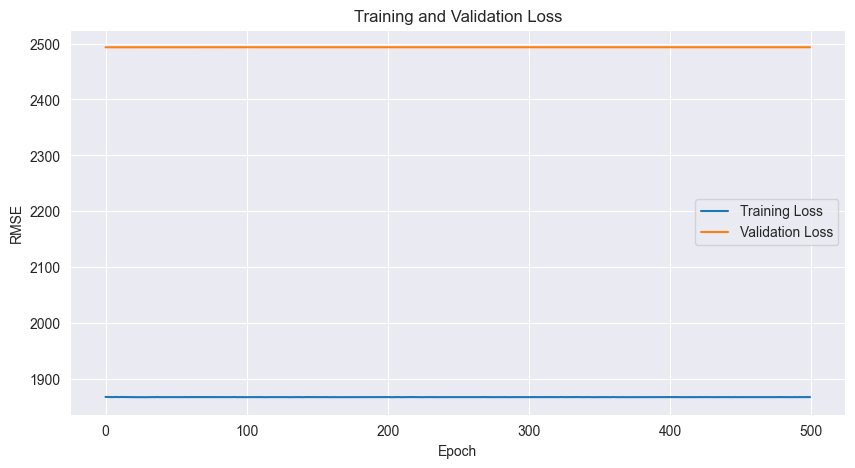

Final validation RMSE: 2493.2173
  Avg RMSE: 2032.3209 ± 417.7714

Testing: hidden_size=128, layers=5, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:02<00:00, 168.05it/s]


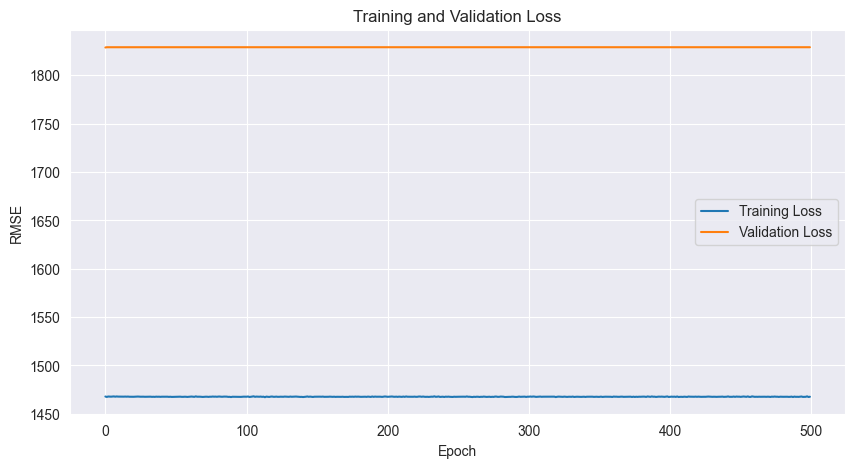

Final validation RMSE: 1828.7311
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:03<00:00, 151.94it/s]


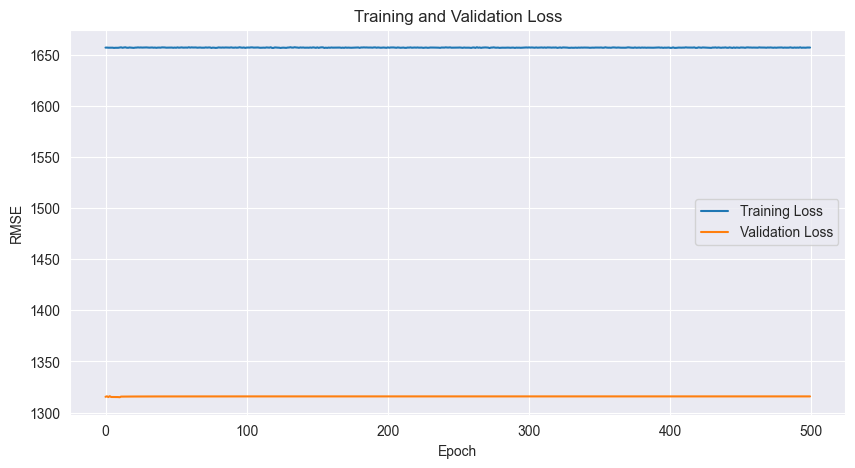

Final validation RMSE: 1315.0455
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 123.86it/s]


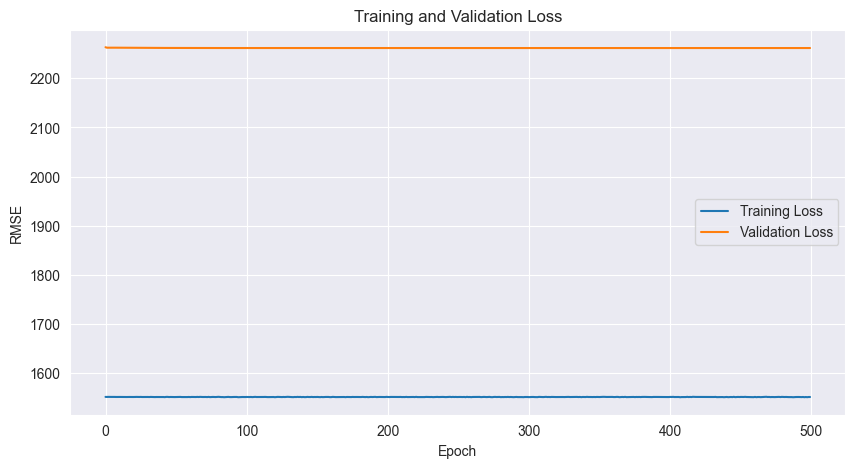

Final validation RMSE: 2261.2639
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 114.50it/s]


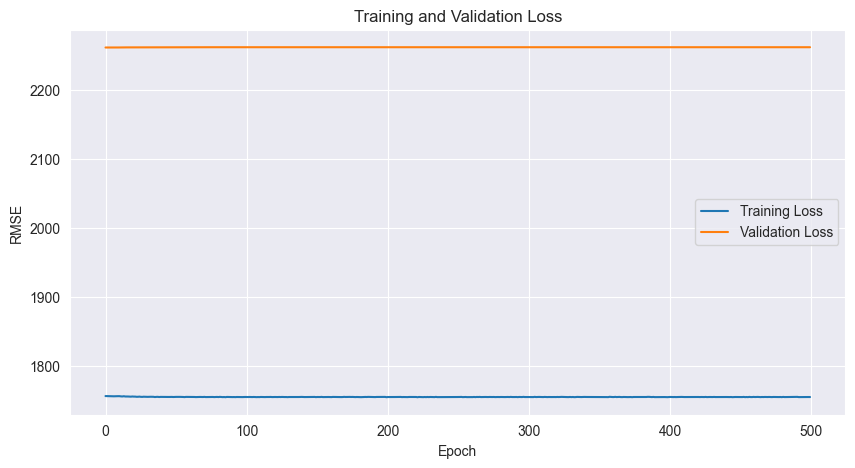

Final validation RMSE: 2261.8254
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 86.95it/s]


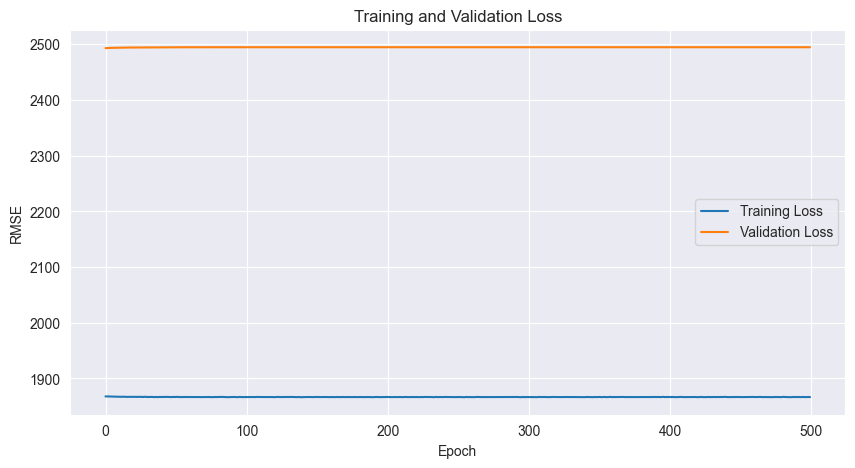

Final validation RMSE: 2493.1497
  Avg RMSE: 2032.0031 ± 417.9432

Testing: hidden_size=128, layers=10, lr=0.0001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 96.34it/s] 


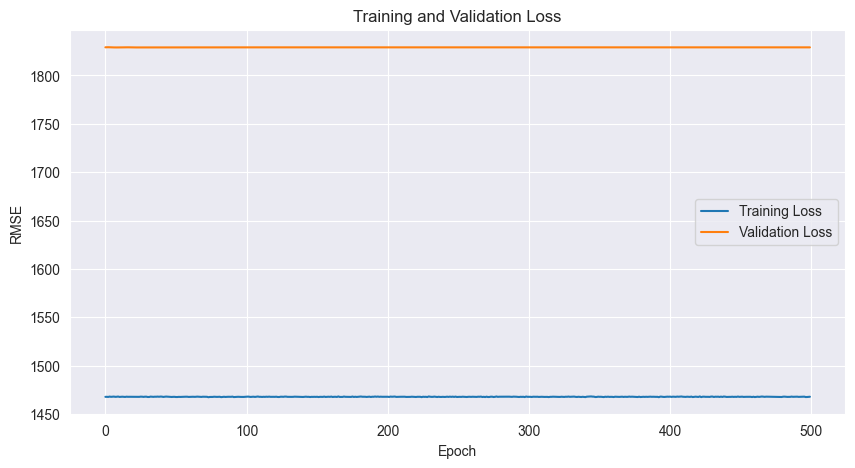

Final validation RMSE: 1828.9618
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 87.47it/s]


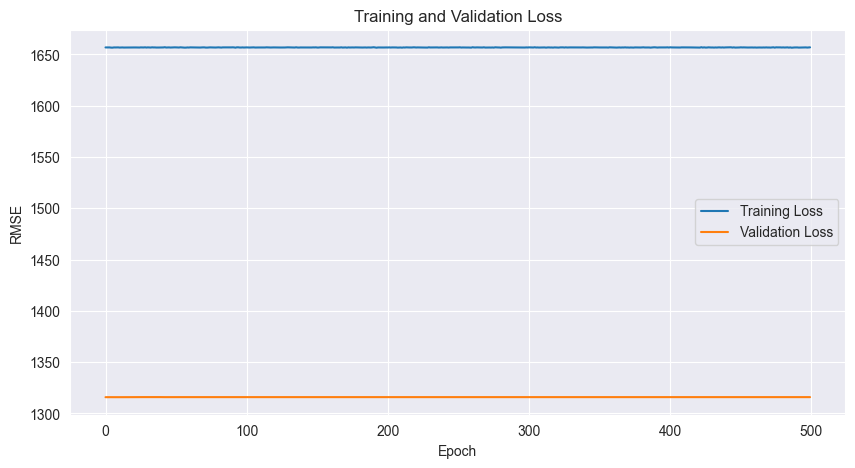

Final validation RMSE: 1315.7301
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 71.45it/s]


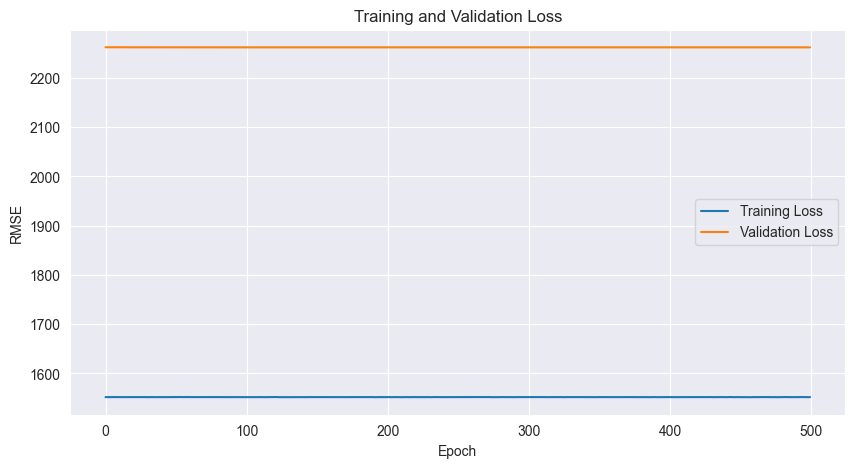

Final validation RMSE: 2262.0859
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 63.04it/s]


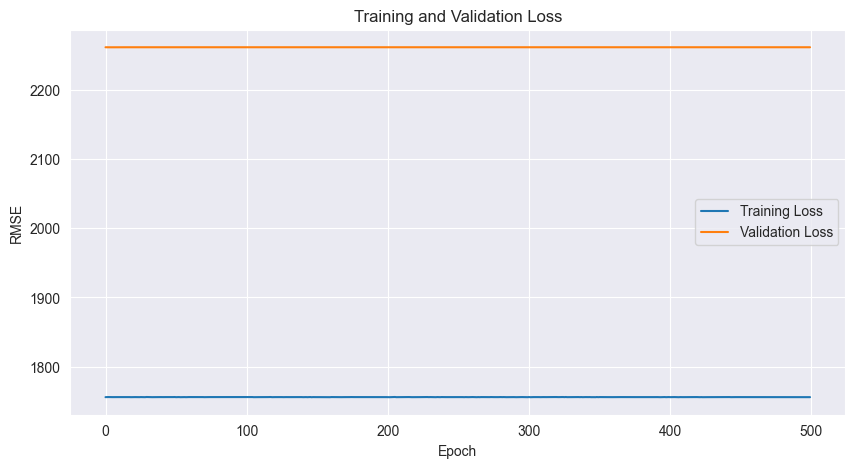

Final validation RMSE: 2261.7446
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:10<00:00, 48.67it/s]


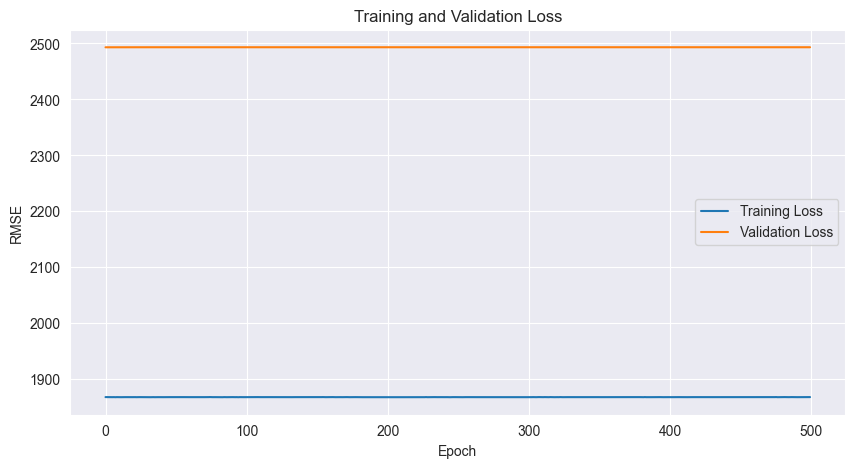

Final validation RMSE: 2493.1606
  Avg RMSE: 2032.3366 ± 417.7697

Testing: hidden_size=128, layers=10, lr=0.001
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:05<00:00, 93.58it/s] 


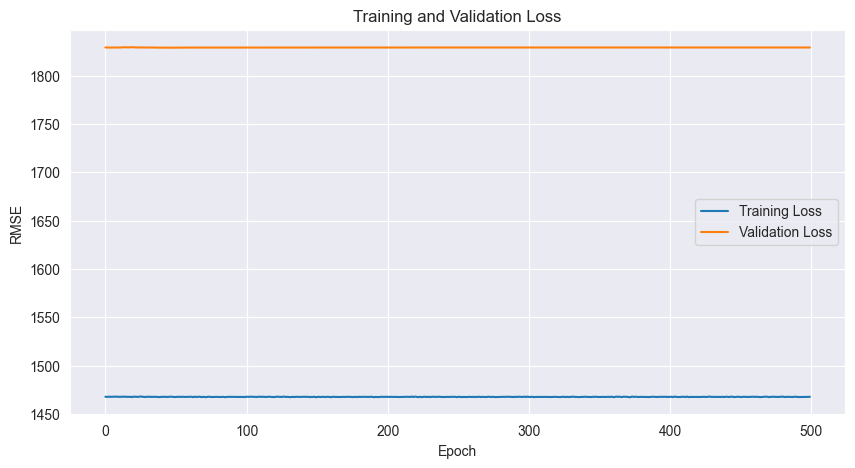

Final validation RMSE: 1828.7986
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 81.55it/s]


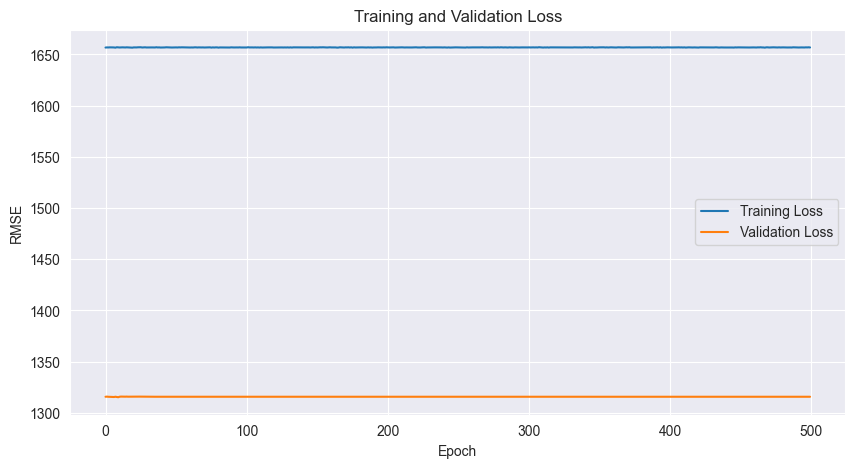

Final validation RMSE: 1315.1981
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 68.57it/s]


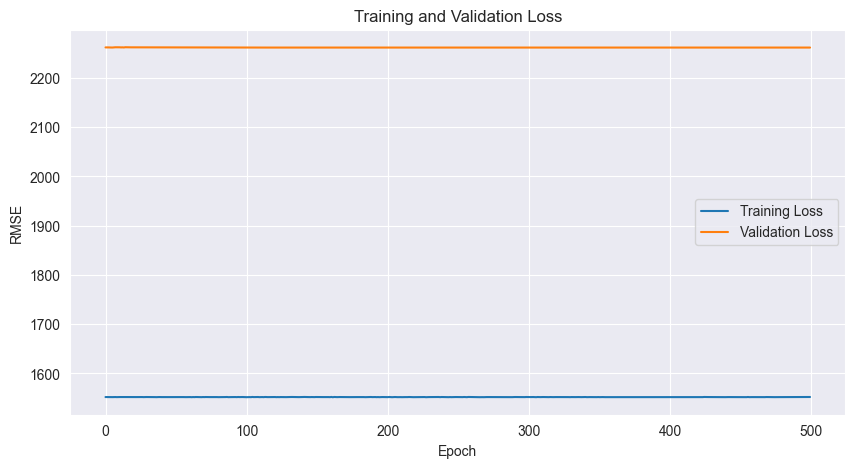

Final validation RMSE: 2261.8337
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:08<00:00, 61.39it/s]


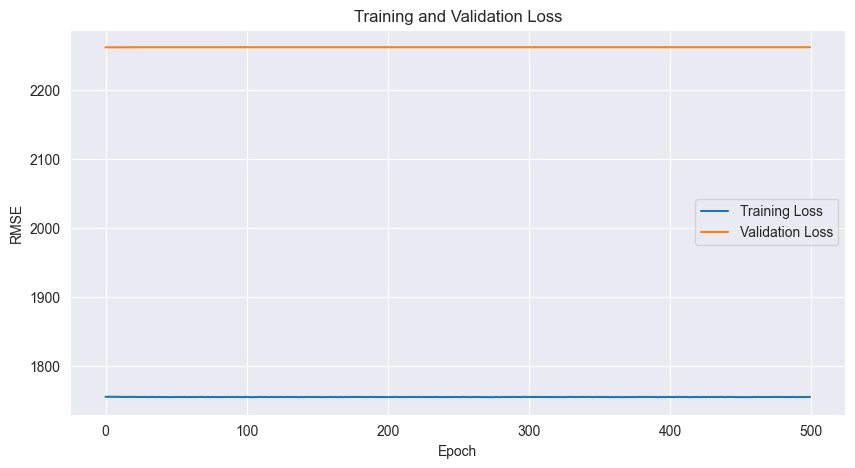

Final validation RMSE: 2261.6960
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:10<00:00, 45.59it/s]


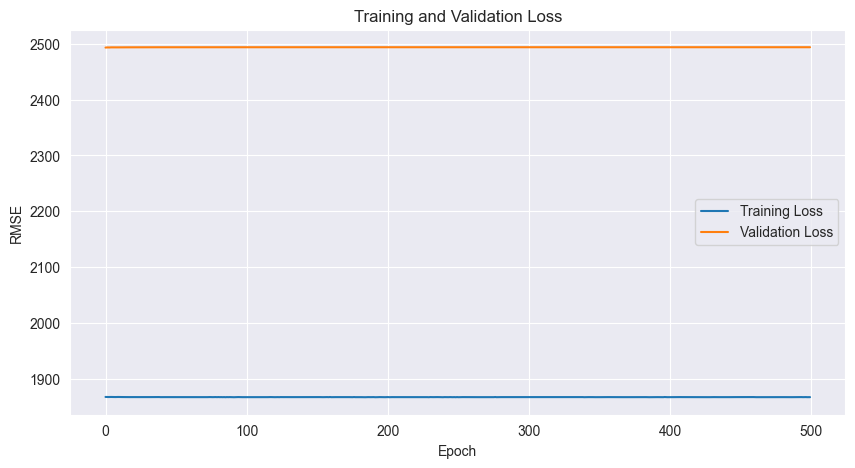

Final validation RMSE: 2492.9622
  Avg RMSE: 2032.0977 ± 417.8913

Testing: hidden_size=128, layers=10, lr=0.01
  Fold 1/5
Input size: 437



100%|██████████| 500/500 [00:04<00:00, 101.84it/s]


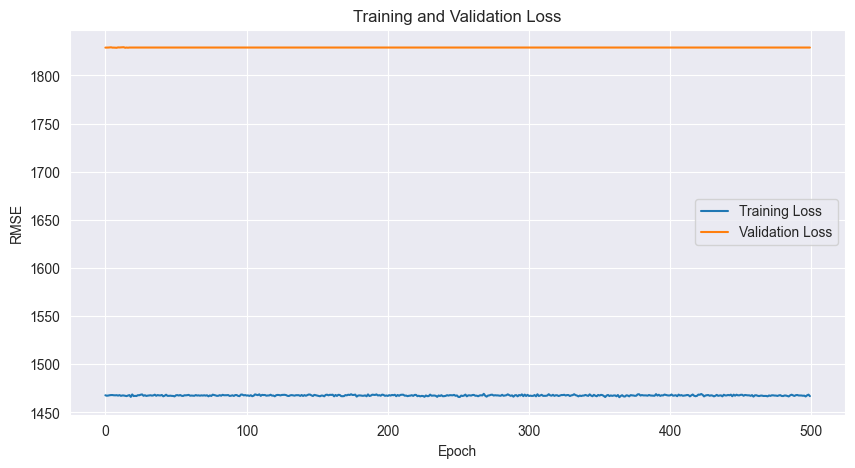

Final validation RMSE: 1828.8051
  Fold 2/5
Input size: 437



100%|██████████| 500/500 [00:06<00:00, 77.89it/s]


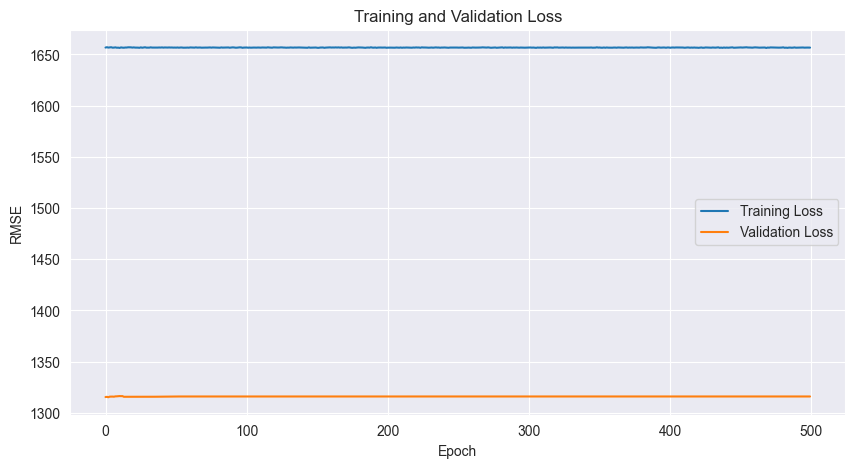

Final validation RMSE: 1315.2329
  Fold 3/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 68.63it/s]


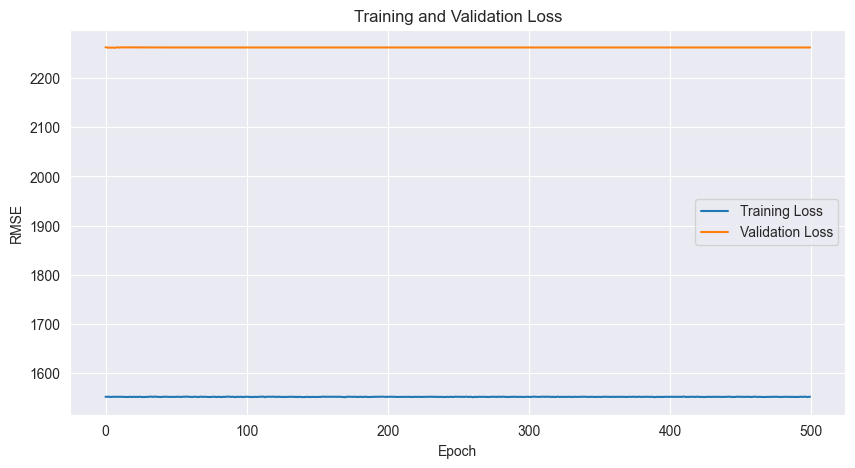

Final validation RMSE: 2261.5264
  Fold 4/5
Input size: 437



100%|██████████| 500/500 [00:07<00:00, 65.09it/s]


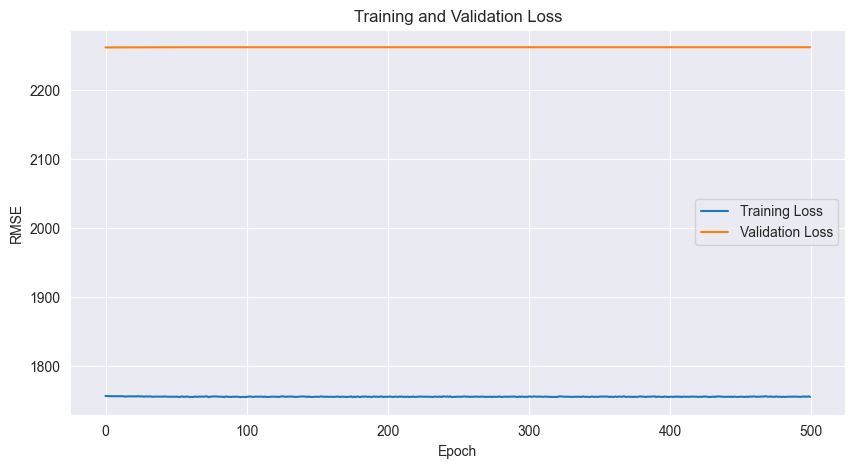

Final validation RMSE: 2261.8586
  Fold 5/5
Input size: 437



100%|██████████| 500/500 [00:09<00:00, 50.05it/s]


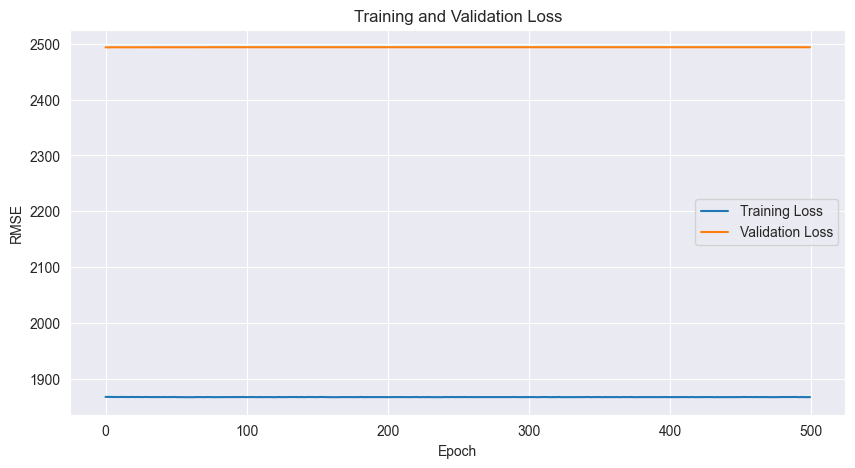

Final validation RMSE: 2493.1462
  Avg RMSE: 2032.1138 ± 417.9034

Best parameters: hidden_size=64, num_layers=2, learning_rate=0.01
Best average RMSE: 2030.1887

Top 5 models:


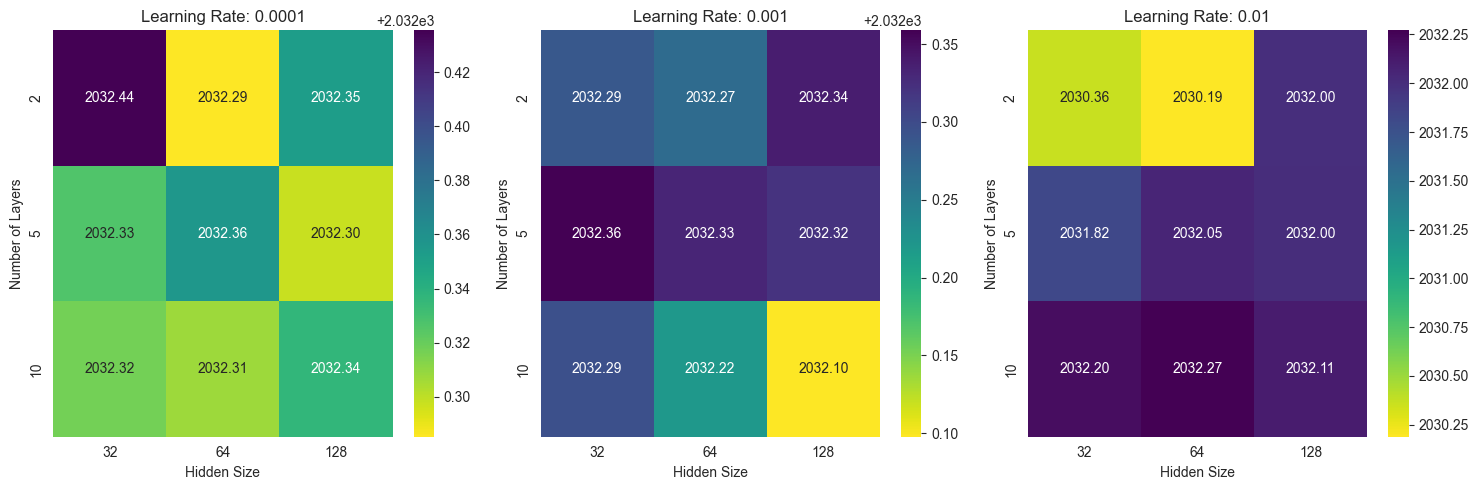

In [16]:
# Define hyperparameter search space (smaller for demonstration)
hidden_sizes = [32, 64, 128]
layers_options = [2, 5, 10]
learning_rates = [1e-4, 1e-3, 1e-2]

# Run hyperparameter tuning
best_params, results_df = tune_hyperparameters(
    X_trains, y_trains, X_tests, y_tests,
    hidden_sizes=hidden_sizes,
    layers_options=layers_options,
    learning_rates=learning_rates,
    epochs=500,  # Reduced for faster tuning
    verbose=True
)

# Display top 5 models
print("\nTop 5 models:")
results_df[['hidden_size', 'num_layers', 'learning_rate', 'avg_rmse', 'std_rmse']].head(5)

# Visualize results with a heatmap
plt.figure(figsize=(15, 5))

# Create pivot tables for each learning rate
for i, lr in enumerate(learning_rates):
    plt.subplot(1, len(learning_rates), i+1)
    
    # Filter for current learning rate and pivot
    df_lr = results_df[results_df['learning_rate'] == lr]
    pivot = df_lr.pivot_table(
        index='num_layers', 
        columns='hidden_size', 
        values='avg_rmse'
    )
    
    # Plot heatmap
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis_r')
    plt.title(f'Learning Rate: {lr}')
    plt.ylabel('Number of Layers')
    plt.xlabel('Hidden Size')

plt.tight_layout()
plt.show()